In [1]:
import numpy as np
import os
from google.colab import drive
import pickle
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
from scipy.optimize import minimize
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Creating Environment

In [2]:

class GridWorld:
    def __init__(self, height, width, start, end, bad_region_clusters, good_region_clusters, final_reward, sparsity):
        self.height = height
        self.width = width
        self.start = start
        self.end = end
        self.bad_region_clusters = bad_region_clusters
        self.good_region_clusters = good_region_clusters
        # self.good_region_reward = good_region_reward
        # self.bad_region_reward = bad_region_reward
        self.final_reward = final_reward
        self.sparsity = sparsity

        self.state_rewards = self.generate_state_rewards()
        self.reset()

    def reset(self):
        self.agent_position = self.start


    def generate_state_rewards(self):
        state_rewards = {}
        for x in range(self.width):
            for y in range(self.height):
                state_reward = 0.0

                if (x, y) == self.start:
                    state_reward = 0.0
                elif (x, y) == self.end:
                    state_reward = self.final_reward
                else:
                    for cluster in self.good_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    for cluster in self.bad_region_clusters:
                        for point, reward in cluster:
                            if (x, y) == point:
                                state_reward += reward

                    if state_reward == 0.0:
                        state_reward = 0.5 if np.random.random() < self.sparsity else 0.0

                state_rewards[(x, y)] = state_reward

        return state_rewards


    def step(self, action):
        x, y = self.agent_position

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get((x, y), 0)

        if action == "up" and y < self.height - 1:
            y += 1
        elif action == "down" and y > 0:
            y -= 1
        elif action == "left" and x > 0:
            x -= 1
        elif action == "right" and x < self.width - 1:
            x += 1

        # Update agent position
        self.agent_position = (x, y)

        # Get the reward based on the current state and policy context
        reward = self.state_rewards.get(self.agent_position, 0)


        if self.agent_position in self.end:
            done = True
        else:
            done = False

        # Get the reward for the updated position and policy context
        updated_reward = self.state_rewards.get(self.agent_position, 0)

        # Check if the new position is the end state
        done = (self.agent_position == self.end)

        return self.agent_position, updated_reward, done



In [3]:
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
# bad_cluster_2 = [((1, 0), -0.5), ((1, 1), -0.5)]
# good_cluster = []

# # Create an instance of GridWorld
# gridworld = GridWorld(
#     height=5,
#     width=5,
#     start=(0, 0),
#     end=(4, 4),
#     bad_region_clusters=[bad_cluster_1, bad_cluster_2],
#     good_region_clusters=[good_cluster],
#     final_reward=10,
#     sparsity=0.0
# )

# # Access the state_rewards dictionary
# rewards = gridworld.state_rewards

# # Print the rewards for each state
# for state, reward in rewards.items():
#     print(f"State: {state}, Reward: {reward}")

In [4]:
import numpy as np

class Agent:
    def __init__(self, epsilon=0.2):
        self.epsilon = epsilon

    def select_action(self, policy_func):
        if np.random.uniform() < self.epsilon:
            # Choose a random action
            action = np.random.choice(["up", "down", "left", "right"])
        else:
            # Use the provided policy function to get the best action
            action = policy_func()
        return action

# Define different policy functions outside the class

def random_policy():
    # Choose a random action
    return np.random.choice(["up", "down", "left", "right"])

# def behavior_policy(behav_policy):
#     action_probs = behav_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def evaluation_policy(eval_policy):
#     action_probs = eval_policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

# def run_policy(policy):
#     action_probs = policy
#     return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))

def run_policy(agent_position, quadrant_policy_map):
    action_probs = get_quadrant_policy(agent_position, quadrant_policy_map)
    return np.random.choice(list(action_probs.keys()), p=list(action_probs.values()))


def manhattan_distance(pos1, pos2):
    # Compute the Manhattan distance between two positions
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])


In [5]:
height = 5
width = 5

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_quadrant_probs = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_quadrant_probs = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}


# Define a function to select the policy based on quadrant
def get_quadrant_policy(position, policy_map):
    x, y = position
    if x < mid_x:
        if y < mid_y:
            return policy_map["bottom_left"]
        else:
            return policy_map["top_left"]
    else:
        if y < mid_y:
            return policy_map["bottom_right"]
        else:
            return policy_map["top_right"]

# Update behav_policy and eval_policy with quadrant-based distributions
# behav_policy = get_quadrant_policy(agent_position, behav_quadrant_probs)
# eval_policy = get_quadrant_policy(agent_position, eval_quadrant_probs)


In [6]:
get_quadrant_policy((1,2),behav_quadrant_probs)

{'up': 0.2, 'down': 0.2, 'left': 0.2, 'right': 0.4}

# Generating Policy data

In [7]:
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [8]:
# def create_policy_set(env, policy_func, policy, num_episodes):
#   # Create a list to store policies as trajectories
#   policies = []

#   # Run multiple episodes
#   for episode in range(num_episodes):
#       # Create a new Agent for each episode to generate a different policy

#       agent = Agent(epsilon=0.0)

#       # print(episode)
#       # Run an episode
#       env.reset()
#       done = False
#       trajectory = []  # Store the trajectory for the current episode
#       cumulative_reward = 0.0  # Initialize cumulative reward
#       while not done:
#           state = env.agent_position  # Get the current state
#           # print("State: ",state)
#           action = agent.select_action(lambda: policy_func(policy))
#           # print("Action: ",action)
#           next_state, reward, done = env.step(action)
#           # print("Next State: ", next_state)

#           # Compute cumulative reward
#           cumulative_reward += reward


#           # good_region_distances = []
#           # if env.good_region_clusters:
#           #     good_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.good_region_clusters]

#           # bad_region_distances = []
#           # if env.bad_region_clusters:
#           #     bad_region_distances = [round(np.mean([manhattan_distance(state, point) for point, _ in cluster]), 2) for cluster in env.bad_region_clusters]

#           dist_to_terminal = manhattan_distance(state,env.end)

#           # Store the (state, action, reward, next_state) tuple in the trajectory
#           trajectory.append((state, action, reward, next_state, cumulative_reward, dist_to_terminal))

#       # Append the trajectory to the policies list
#       policies.append(trajectory)

#   return policies


In [9]:
def create_policy_set(env, policy_func, policy_map, num_episodes):
    # Create a list to store policies as trajectories
    policies = []

    # eval_policy_map, behav_policy_map = policy_maps  # Extract evaluation and behavior policy maps

    # Run multiple episodes
    for episode in range(num_episodes):
        # Create a new Agent for each episode to generate a different policy
        agent = Agent(epsilon=0.0)

        # Run an episode
        env.reset()
        done = False
        trajectory = []  # Store the trajectory for the current episode
        cumulative_reward = 0.0  # Initialize cumulative reward
        while not done:
            state = env.agent_position  # Get the current state
            action = agent.select_action(lambda: policy_func(state, policy_map))
            next_state, reward, done = env.step(action)
            dist_to_terminal = manhattan_distance(state, env.end)

            # Compute cumulative reward
            cumulative_reward += reward

            # Store the (state, action, reward, next_state) tuple in the trajectory
            trajectory.append((state, action, reward, next_state, cumulative_reward, dist_to_terminal))

        # Append the trajectory to the policies list
        policies.append(trajectory)

    return policies


In [10]:
# pi_b = create_policy_set(gridworld, run_policy, behav_policy, 200)

In [11]:
def calc_V_pi_e(evaluation_policies):
    all_timesteps = []
    gamma = 0.9
    for j in range(len(evaluation_policies)):
        Timestep_values = []
        for i in range(len(evaluation_policies[j])):
          # print(i)
          timestep = gamma ** (i) * evaluation_policies[j][i][2]
          Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_est = sum([sum(sublist) for sublist in all_timesteps])/len(evaluation_policies)
    return V_est

# Saving and Loading Data

In [12]:
def filename(env, behav_policy, eval_policy, num_episodes, train_split, sparsity):
    good_clusters_str = "_".join([f"gc_{cluster_string(cluster)}" for cluster in env.good_region_clusters])
    bad_clusters_str = "_".join([f"bc_{cluster_string(cluster)}" for cluster in env.bad_region_clusters])

    # behav_probs_str = "_".join([f"{prob:.2f}" for prob in behav_policy.values()])
    # eval_probs_str = "_".join([f"{prob:.2f}" for prob in eval_policy.values()])

    file = f"{good_clusters_str}_{bad_clusters_str}_trajectories_{num_episodes}_train_split_{train_split}_sparsity_{sparsity}.txt"
    return file

def cluster_string(cluster):
    return "_".join([f"point_{pos[0]}_{pos[1]}_{reward:.2f}" for pos, reward in cluster])


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:

# Define the path to your desired folder
folder_path = '/content/drive/MyDrive/gridworld_ope_distance_to_terminal_complex'

# Change the working directory to the specified folder
os.chdir(folder_path)


In [15]:

def save_data_to_file(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

def load_data_from_file(filename):
    with open(filename, 'rb') as file:
        data = pickle.load(file)
    return data


# OPE Calculations

## Importance Weights

In [16]:
# def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
#   all_weights = []
#   for trajectory in behavior_policies:
#     cum_ratio = 1
#     cumul_weights = []
#     for step in trajectory:
#         ratio = eval_policy[step[1]]/behav_policy[step[1]]
#         # print("Ratio:",ratio)
#         cum_ratio *= ratio
#         cumul_weights.append(cum_ratio)
#         # print("Cumul:",cum_ratio)
#     all_weights.append(cumul_weights)

#   return all_weights

In [17]:
def calculate_importance_weights(eval_policy, behav_policy, behavior_policies):
    all_weights = []
    for trajectory in behavior_policies:
        cum_ratio = 1
        cumul_weights = []
        for step in trajectory:
            eval_action_probs = get_quadrant_policy(step[0], eval_policy)
            behav_action_probs = get_quadrant_policy(step[0], behav_policy)
            ratio = (0.8*eval_action_probs[step[1]] +0.2*0.25)/ (0.8*behav_action_probs[step[1]]+0.2*0.25)
            cum_ratio *= ratio
            cumul_weights.append(cum_ratio)
        all_weights.append(cumul_weights)

    return all_weights


## IS

In [18]:

def per_step_IS1(scope_set, num_bootstraps, eval_policy, behav_policy):
    all_timesteps = []
    gamma = 0.9
    # scope_set,_ = subset_policies(scope_set, phi_trajectories)
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_set)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            timestep = gamma ** (i) * scope_weights[j][i] * scope_set[j][i][2]
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]


    num_trajectories_to_sample = max(1, len(V_per_traj))


    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    std_devs = []
    means = []

    seed_value = 0
    np.random.seed(seed_value)

    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_set) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }



## SCOPE

In [19]:

def SCOPE1(scope_policies, beta, num_bootstraps, eval_policy, behav_policy):
    all_timesteps = []
    gamma = 0.9
    scope_weights = calculate_importance_weights(eval_policy, behav_policy, scope_policies)
    for j in range(len(scope_weights)):
        Timestep_values = []
        for i in range(len(scope_weights[j]) - 1):
            features = scope_policies[j][i][5]
            features_next = scope_policies[j][i + 1][5]
            timestep = gamma ** (i) * scope_weights[j][i] * (scope_policies[j][i][2] + gamma * phi(features_next, beta) - phi(features, beta))
            Timestep_values.append(timestep)

        all_timesteps.append(Timestep_values)

    features_0 = scope_policies[0][0][5]
    shaped = phi(features_0,beta)

    V_per_traj = [sum(sublist) for sublist in all_timesteps]
    num_trajectories_to_sample = max(1, len(V_per_traj))

    V_per_traj_shaped = [x - shaped for x in V_per_traj]


    std_devs = []
    means = []
    seed_value = 0
    np.random.seed(seed_value)
    for i in range(5):

      bootstrap_samples = [np.random.choice(V_per_traj_shaped, size=num_trajectories_to_sample, replace=True)
                            for _ in range(num_bootstraps)]

      V_per_sample = [sum(sample)/len(scope_policies) for sample in bootstrap_samples]
      V_per_sample = np.array(V_per_sample)

      std_deviation = np.std(V_per_sample)
      quartiles = np.percentile(V_per_sample, [0,25, 50, 75,100])
      max_value = np.max(V_per_sample)
      min_value = np.min(V_per_sample)
      mean = np.mean(V_per_sample)

      std_devs.append(std_deviation)
      means.append(mean)

    return {
        'std_devs_list': std_devs,
        'mean_list': means
    }


In [20]:
# V_per_traj_shaped = SCOPE1(scope_set, 0.5, 100)
# bootstrap_samples = [np.random.choice(V_per_traj_shaped, size=len(V_per_traj_shaped), replace=True) for _ in range(100)]

# Variance Preparation and Calculation

## Phi functions

In [21]:
def phi(features, beta):
  features = np.array(features)
  beta = np.array(beta)
  phi_linear = np.dot(beta,features)
  return phi_linear


In [22]:
def phi2(features, beta):
    features = np.array(features)
    beta = np.array(beta)

    # Calculate the matrix multiplication and then element-wise multiplication
    phi_quadratic = np.dot(features, np.dot(beta, features.T))

    return phi_quadratic

## Subset Policies

In [23]:

def subset_policies(policies, percent_to_estimate_phi):
    # seed_value = 0
    # np.random.seed(seed_value)
    num_policies = len(policies)
    num_policies_to_estimate_phi = int(num_policies * percent_to_estimate_phi)

    policies_for_scope = policies[num_policies_to_estimate_phi:]
    policies_for_phi = policies[:num_policies_to_estimate_phi]

    return policies_for_scope, policies_for_phi


## Variance Terms

In [24]:
import random
# gamma = 0.9
# beta = [random.random() for _ in range(3)]
def variance_terms(policy_set,gamma, beta, eval_policy, behav_policy):
  all_weights = calculate_importance_weights(eval_policy, behav_policy, policy_set)
  y_w_r_all = 0
  r_all = 0
  f_a = 0
  for n in range(len(policy_set)):
    y_w_r = 0
    r = 0
    for t in range(len(policy_set[n])-1):
      features = policy_set[n][t][5]
      y_w_r += gamma**(t)*all_weights[n][t]*policy_set[n][t][2]
      if t>0:
        r += phi(features, beta)*(all_weights[n][t-1]-all_weights[n][t])
    features_last = policy_set[n][-1][5]
    features_first = policy_set[n][0][5]
    y_w_r_all += y_w_r
    f_a +=  gamma**(len(policy_set[n]))*all_weights[n][-1]*phi(features_last,beta) - phi(features_first, beta)
    r_all += r

  IS = y_w_r_all/len(policy_set)
  R = r_all/len(policy_set)
  F = f_a/len(policy_set)
  return IS, R, F


In [25]:
def calc_variance(phi_policies, gamma, beta, num_bootstrap_samples, eval_policy, behav_policy):
  # Set the seed value (you can use any integer value)
  seed_value = 0
  np.random.seed(seed_value)
  num_trajectories_to_sample = max(1, len(phi_policies))

  bootstrap_samples = [np.random.choice(phi_policies, size=num_trajectories_to_sample, replace=True)
                         for _ in range(num_bootstrap_samples)]
  IS_all = []
  R_all = []
  F_all = []

  for pol in bootstrap_samples:
    IS, R, F = variance_terms(pol,0.9,beta, eval_policy, behav_policy)
    IS_all.append(IS)
    R_all.append(R)
    F_all.append(F)
  IS_sq = np.mean([num**2 for num in IS_all])
  IS_R_F = 2*np.mean([IS_all[i]*(R_all[i]+F_all[i]) for i in range(len(IS_all))])
  R_sq = np.mean([num**2 for num in R_all])
  IS_sq_all = (np.mean(IS_all))**2
  IS_r_t_f = 2*np.mean(IS_all)*np.mean([R_all[i]+F_all[i] for i in range(len(R_all))])
  R_sq_all = (np.mean(R_all))**2

  variance_scope = IS_sq + IS_R_F + R_sq - IS_sq_all - IS_r_t_f - R_sq_all
  variance_is = IS_sq - IS_sq_all
  return variance_scope, variance_is

# Optimization

Here we aim to optimize beta to minimize SCOPE variance.

In [26]:
# Define the objective function to minimize variance_scope
def objective_function(beta, phi_set, eval_policy, behav_policy):
    # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
    variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100, eval_policy, behav_policy)
    return variance_scope

# Set the initial values of beta
# initial_beta = np.array([ 0.2610704,   0.30396575, -0.43850237])


def optimize_variance_scope(initial_beta, phi_set, phi_trajectories, eval_policy, behav_policy):
    # Lists to store beta and variance_scope values at each iteration
    all_betas = []
    all_variance_scopes = []

    # Callback function to record beta and variance_scope values at each iteration
    def callback_function(beta):
        all_betas.append(beta.copy())
        variance_scope = objective_function(beta, phi_set,eval_policy, behav_policy)
        all_variance_scopes.append(variance_scope)
        print("Iteration:", len(all_betas))
        print("Beta:", beta)
        print("Variance Scope:", variance_scope)
        print("----------")

    # Run the optimization with the callback
    result = minimize(
        objective_function,
        initial_beta,
        args=(phi_set, eval_policy, behav_policy),
        method='L-BFGS-B',
        callback=callback_function
    )

    # Extract the optimal beta values
    optimal_beta = result.x

    return optimal_beta


# Optimization with bounds

In [27]:
# from scipy.optimize import minimize

# # Define the bounds for each beta
# def bounds_generator(env):
#     bounds = []
#     num_good_clusters = len(env.good_region_clusters)
#     num_bad_clusters = len(env.bad_region_clusters)

#     for _ in range(num_good_clusters):
#         bounds.append((None, 0))  # Negative or zero for good clusters

#     for _ in range(num_bad_clusters):
#         bounds.append((0, None))  # Positive or zero for bad clusters

#     return bounds


# # Define the objective function to minimize variance_scope
# def objective_function(beta, phi_set):
#     # scope_set, phi_set = subset_policies(phi_set, phi_trajectories)
#     variance_scope, variance_is = calc_variance(phi_set, 0.9, beta, 100)
#     return variance_scope

# # Set the initial values of beta
# # initial_beta = [random.uniform(-0.5, 0.5) for _ in range(len(env.good_region_clusters) + len(env.bad_region_clusters))]

# def optimize_variance_scope(initial_beta, phi_set, phi_trajectories, env):
#     # Lists to store beta and variance_scope values at each iteration
#     all_betas = []
#     all_variance_scopes = []

#     # Callback function to record beta and variance_scope values at each iteration
#     def callback_function(beta):
#         all_betas.append(beta.copy())
#         variance_scope = objective_function(beta, phi_set)
#         all_variance_scopes.append(variance_scope)
#         print("Iteration:", len(all_betas))
#         print("Beta:", beta)
#         print("Variance Scope:", variance_scope)
#         print("----------")

#     # Generate bounds based on the environment
#     bounds = bounds_generator(env)

#     # Run the optimization with the callback
#     result = minimize(
#         objective_function,
#         initial_beta,
#         args=(phi_set),
#         method='L-BFGS-B',
#         bounds=bounds,
#         callback=callback_function
#     )

#     # Extract the optimal beta values
#     optimal_beta = result.x

#     return optimal_beta


In [28]:
# bounds_generator(gridworld)

# Playground to run individual trajectories

In [29]:
# height = 5
# width = 5

# # Define the quadrants of the gridworld based on midpoint
# mid_x = width // 2
# mid_y = height // 2

# # Define probability distributions for each quadrant
# behav_policy = {
#     "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
#     "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
# }

# # Define probability distributions for each quadrant
# eval_policy = {
#     "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
#     "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
#     "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
#     "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
# }

In [30]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]
# # good_cluster = [((4, 2), 1), ((4, 3), 0)]

# # Create an instance of GridWorld
# gridworld = GridWorld(
#     height=5,
#     width=5,
#     start=(0, 0),
#     end=(4, 4),
#     bad_region_clusters=[bad_cluster_1],
#     good_region_clusters=[good_cluster_1],
#     final_reward=10,
#     sparsity=0.0
# )

# # Access the state_rewards dictionary
# rewards = gridworld.state_rewards

# # Print the rewards for each state
# for state, reward in rewards.items():
#     print(f"State: {state}, Reward: {reward}")

# behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 200)


In [31]:
# # env = GridWorld(height, width, start, end, [(1, 1), (2, 2)], [], 1, -2, 3, 0.1)
# # behavior_policies = create_policy_set(gridworld, run_policy,behav_policy, 200)
# initial_beta = random.uniform(-0.5, 0.5)
# scope_set, phi_set = subset_policies(behavior_policies, 0.3)
# # # bounds = bounds_generator(gridworld)

# optimal_beta = optimize_variance_scope(initial_beta, phi_set, 0.3,eval_policy, behav_policy)
# variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500,eval_policy, behav_policy)
# print("Var SCOPE_phi: ",variance_scope)
# print("Var IS_phi: ",variance_is)
# print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)

In [32]:
# scope_results = SCOPE1(scope_set,optimal_beta[0],500,eval_policy, behav_policy)
# IS_results = per_step_IS1(scope_set,500,eval_policy, behav_policy)
# print("SCOPE results: ", scope_results)
# print("IS results: ", IS_results)
# evaluation_policies = create_policy_set(gridworld, run_policy,eval_policy, 1000)
# true_evaluation = calc_V_pi_e(evaluation_policies)
# print("true eval: ", true_evaluation)

# Modify Data

In [33]:
# def modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
#   file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
#   # Check if the file already exists
#   if os.path.exists(file):
#     loaded_data = load_data_from_file(file)
#     behavior_policies = loaded_data['policy_set']
#     scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
#     beta = loaded_data['optimal_beta']
#     # scope_results = loaded_data['scope_results']
#     scope_results_new = SCOPE1(scope_set,beta,500)
#     IS_results_new = per_step_IS1(scope_set,500)
#     loaded_data['scope_results'] = scope_results_new
#     loaded_data['IS_results'] = IS_results_new
#     true_evals = []
#     for i in range(5):
#       evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
#       true_evaluation = calc_V_pi_e(evaluation_policies)
#       true_evals.append(true_evaluation)
#     loaded_data['True Evaluations'] = true_evals
#     save_data_to_file(loaded_data, file)
#     print("modifying... ")
#     print("scope new: ",scope_results_new)
#     print("IS new: ", IS_results_new)



# Experiment Function

In [34]:
def run_experiment1(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

  behavior_policies = create_policy_set(env, run_policy,behav_policy, num_episodes)
  initial_beta = random.uniform(-0.5, 0.5)
  scope_set, phi_set = subset_policies(behavior_policies, phi_traj)
  optimal_beta = optimize_variance_scope(initial_beta, phi_set, phi_traj,eval_policy, behav_policy)
  variance_scope, variance_is = calc_variance(phi_set,0.9,optimal_beta, 500, eval_policy, behav_policy)
  print("Var SCOPE_phi: ",variance_scope)
  print("Var IS_phi: ",variance_is)
  print("Percent change in variance: ",((variance_scope-variance_is)/variance_is)*100)
  scope_results = SCOPE1(scope_set,optimal_beta[0],500,eval_policy, behav_policy)
  IS_results = per_step_IS1(scope_set,500,eval_policy, behav_policy)
  print("SCOPE results: ", scope_results)
  print("IS results: ", IS_results)
  true_evals = []
  for i in range(5):
    evaluation_policies = create_policy_set(env, run_policy,eval_policy, 1000)
    true_evaluation = calc_V_pi_e(evaluation_policies)
    true_evals.append(true_evaluation)
  print("true eval: ", np.mean(np.array(true_evals)))
  data_to_save = {
    'policy_set': behavior_policies,
    'optimal_beta': optimal_beta,
    'variance_scope_train': variance_scope,
    'variance_IS_train': variance_is,
    'scope_results': scope_results,
    'IS_results': IS_results,
    'True Evaluations': true_evals
  }
  save_data_to_file(data_to_save, file)

  return data_to_save



In [35]:
def run_loaded(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity):
  file = filename(env, behav_policy, eval_policy, num_episodes, phi_traj, sparsity)
  # Check if the file already exists
  if os.path.exists(file):
    loaded_data = load_data_from_file(file)
    # loaded_data = modify_data(env, num_episodes, behav_policy, eval_policy, phi_traj, sparsity)
    return loaded_data

# Plotting Functions

In [36]:
def plot_rewards_over_trajectories1(env, num_trajectories, behav_policy, eval_policy, phi_traj, sparsity):
    # combined_scope = []
    # combined_is = []

    combined_scope_means = []
    combined_scope_std_devs = []
    combined_is_means = []
    combined_is_std_devs = []

    combined_scope_vars = []
    combined_scope_var_std_devs = []
    combined_is_vars = []
    combined_is_var_std_devs = []

    combined_scope_bias = []
    combined_scope_bias_std_devs = []
    combined_is_bias = []
    combined_is_bias_std_devs = []

    combined_scope_mse = []
    combined_is_mse = []


    for i in range(len(num_trajectories)):
        results = run_loaded(env, num_trajectories[i], behav_policy, eval_policy, phi_traj, sparsity)
        print("Trajectories: ", num_trajectories[i])
        # if num_trajectories[i] == 200:
        true_val = results['True Evaluations']
        print("True Val: ",true_val)

        optimal_beta = results['optimal_beta']
        print("Optimal Beta: ", optimal_beta)

        true_value = np.mean(np.array(true_val))
        scope_results = results['scope_results']
        is_results = results['IS_results']

        print('SCOPE Results: ', scope_results)
        print('IS Results: ', is_results)

        sd_scope = scope_results['std_devs_list']
        sd_is = is_results['std_devs_list']

        means_scope = scope_results['mean_list']
        means_is = is_results['mean_list']

        combined_scope_means.append(np.mean(np.array(means_scope)))
        combined_scope_std_devs.append(np.std(np.array(means_scope)))
        combined_is_means.append(np.mean(np.array(means_is)))
        combined_is_std_devs.append(np.std(np.array(means_is)))

        combined_scope_vars.append(np.mean(np.array(sd_scope)**2))
        combined_scope_var_std_devs.append(np.std(np.array(sd_scope)**2))
        combined_is_vars.append(np.mean(np.array(sd_is)**2))
        combined_is_var_std_devs.append(np.std(np.array(sd_is)**2))


        combined_scope_bias.append(np.mean(np.array(means_scope)-np.array(true_val)))
        combined_scope_bias_std_devs.append(np.std(np.array(means_scope)-np.array(true_val)))
        combined_is_bias.append(np.mean(np.array(means_is)-np.array(true_val)))
        combined_is_bias_std_devs.append(np.std(np.array(means_is)-np.array(true_val)))

        mse_scope = np.mean(np.array(sd_scope)**2) + (np.mean(np.array(means_scope)-np.array(true_val)))**2
        # print("mse_scope: ", mse_scope)
        combined_scope_mse.append(mse_scope)
        combined_is_mse.append(np.mean(np.array(sd_is)**2) + (np.mean(np.array(means_is)-np.array(true_val)))**2)

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_vars, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_vars, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_vars, yerr=combined_scope_var_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_vars, yerr=combined_is_var_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Variance')
    plt.title('SCOPE and stepIS Variance Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




    plt.figure()

    plt.figure()
    # Plotting
    plt.plot(num_trajectories, combined_scope_bias, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_bias, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_bias, yerr=combined_scope_bias_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_bias, yerr=combined_is_bias_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Bias')
    plt.title('SCOPE and stepIS Bias Plots vs. Number of Trajectories')
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()



    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_means, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_means, color='black', marker='o', label='stepIS')
    plt.errorbar(num_trajectories, combined_scope_means, yerr=combined_scope_std_devs, fmt='bs', label='SCOPE')
    plt.errorbar(num_trajectories, combined_is_means, yerr=combined_is_std_devs, fmt='ko', label='stepIS')

    plt.xlabel('Number of Trajectories')
    plt.ylabel('Value Estimate')
    plt.title('SCOPE and stepIS Value Estimate Plots vs. Number of Trajectories')

    # Add horizontal line for true_val
    plt.axhline(y=true_value, color='green', linestyle='--', label='True Value')

    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS'),
        Line2D([0], [0], color='green', linestyle='--', label='True Value')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()

    plt.figure()

    # Plotting
    plt.plot(num_trajectories, combined_scope_mse, color='blue', marker='s', label='SCOPE')
    plt.plot(num_trajectories, combined_is_mse, color='black', marker='o', label='stepIS')


    plt.xlabel('Number of Trajectories')
    plt.ylabel('MSE')
    plt.title('SCOPE and stepIS MSE Plots vs. Number of Trajectories')


    # Create custom legend handles and labels
    custom_legend_handles = [
        Line2D([0], [0], color='blue', marker='s', markersize=10, label='SCOPE'),
        Line2D([0], [0], color='black', marker='o', markersize=10, label='stepIS')
    ]

    plt.legend(handles=custom_legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()  # Ensures proper spacing and avoids clipping
    plt.show()




# Compare Trajectories

In [37]:
def compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, phi_traj, sparsity):
  for i in num_trajectories:
    print("Loading ",i, " trajectories: ")
    run_experiment1(env,i ,behav_policy, eval_policy, phi_traj, sparsity)

  plot_rewards_over_trajectories1(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)
  # plot_mse_over_trajectories(env,num_trajectories,behav_policy, eval_policy, phi_traj,sparsity)

In [38]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

## Dense 2 bad regions, 1 good, sparse environment

In [39]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

In [41]:
# np.random.seed(42)
# # Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
# bad_cluster_2 = [((1, 0), -1), ((1, 1), -1)]
# good_cluster = [((4, 2), 1), ((4, 3), 1)]

# env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
#     good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
# num_trajectories = [200,400, 600, 800,1000]
# compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0)

## Sparse 2 bad, 1 good, sparse environment

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
good_cluster = [((4, 2), 1), ((4, 3), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[good_cluster],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 2 good, Dense 1 bad

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((1, 2), 1), ((1, 1), 0)]
good_cluster_2 = [((4, 2), 1), ((4, 3), 0),((3, 2), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad 1 good

In [ ]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -1), ((3, 3), -1)]
good_cluster_1 = [((4, 2), 1), ((4, 3), 1)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0)

# Sparse, 1 bad, 1 good

In [58]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [2.1058101823183724, 2.0495036811278204, 2.066405930529373, 2.0614145800920496, 2.073080009473554]
Optimal Beta:  [0.00211356]
SCOPE Results:  {'std_devs_list': [0.11794978742193664, 0.11822896641141996, 0.10552515812017561, 0.11362590537926644, 0.11546012200557745], 'mean_list': [0.08332748042594196, 0.08024276202275674, 0.07484506520391059, 0.07695771138167361, 0.08122923100099406]}
IS Results:  {'std_devs_list': [0.11803411532828949, 0.1183424990123556, 0.10561330626203327, 0.11374402463479119, 0.11555998375137683], 'mean_list': [0.11703391463120669, 0.1139793894180431, 0.10857018645278638, 0.11064729527609225, 0.11496184503279205]}
Trajectories:  400
True Val:  [2.045799798248882, 2.1072890242907216, 2.0902243530137934, 1.981288130587357, 2.125085761384015]
Optimal Beta:  [-0.02730327]
SCOPE Results:  {'std_d

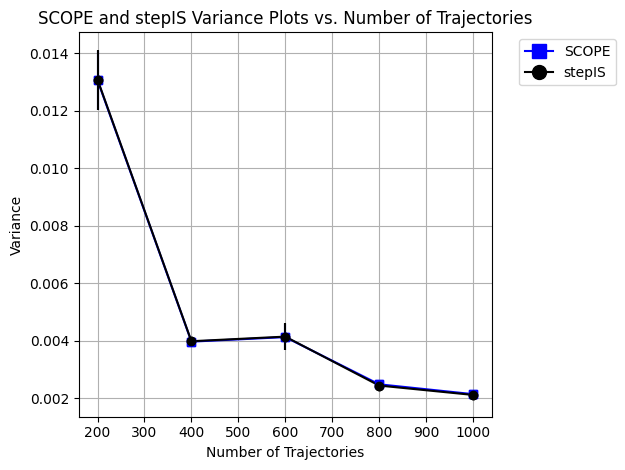

<Figure size 640x480 with 0 Axes>

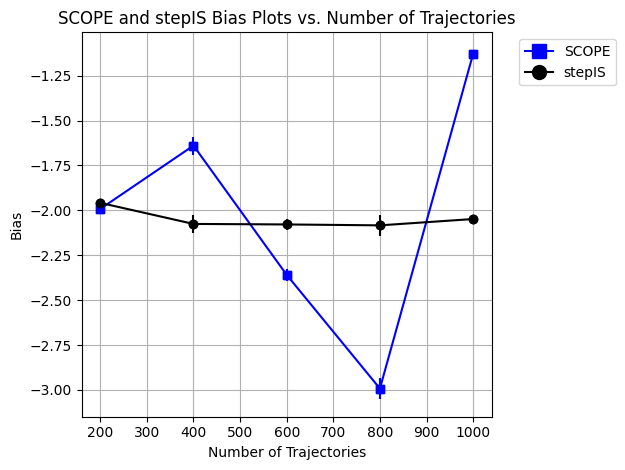

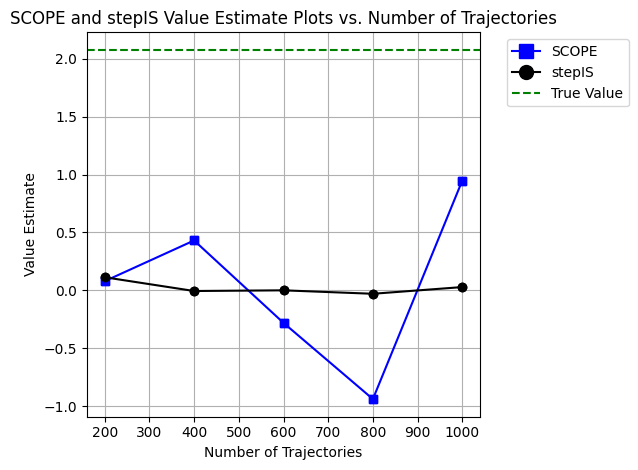

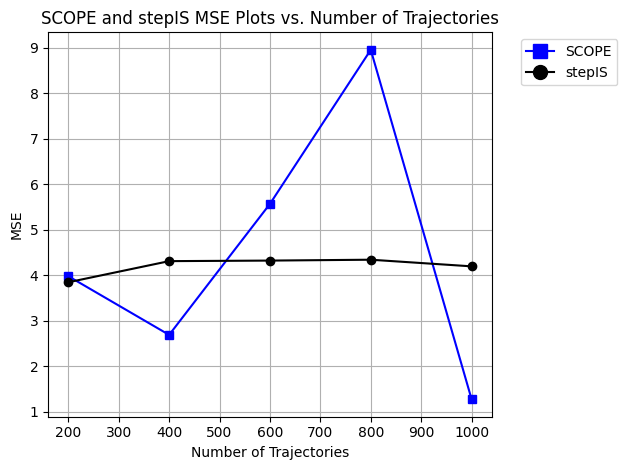

In [44]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), -1), ((3, 3), 0)]
good_cluster_1 = [((4, 2), 1), ((4, 3), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.8539803529445233, 1.8386706650174993, 1.8059860620915977, 1.8066794252137743, 1.7739552744647997]
Optimal Beta:  [-0.05514227]
SCOPE Results:  {'std_devs_list': [0.038713630435504166, 0.03999419759550577, 0.03878498902508525, 0.03840949092277261, 0.03885731733342819], 'mean_list': [0.6502308523787577, 0.6450363783833032, 0.6452085792981691, 0.6496870348216947, 0.6447576811890725]}
IS Results:  {'std_devs_list': [0.04326587070071175, 0.044807512800874465, 0.04262792862852885, 0.042839760456446954, 0.04330676647449321], 'mean_list': [-0.22916235843685429, -0.23514456590053096, -0.23467217223983788, -0.2292665552120836, -0.23531855535312626]}
Trajectories:  400
True Val:  [1.7939484023597323, 1.8602201282458135, 1.8399319431193557, 1.749281259541752, 1.8586057173059667]
Optimal Beta:  [-0.04444921]
SCOPE Results:

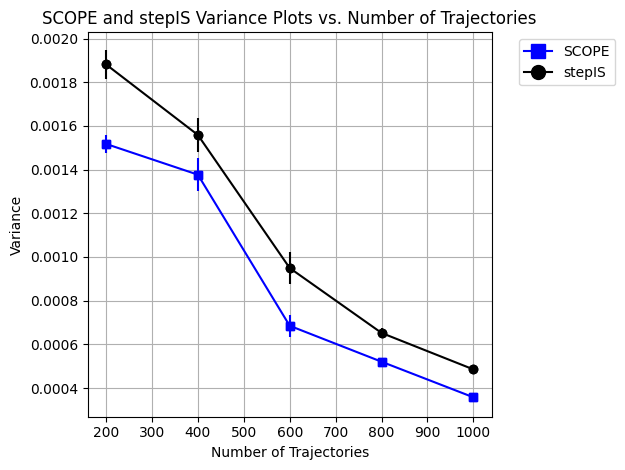

<Figure size 640x480 with 0 Axes>

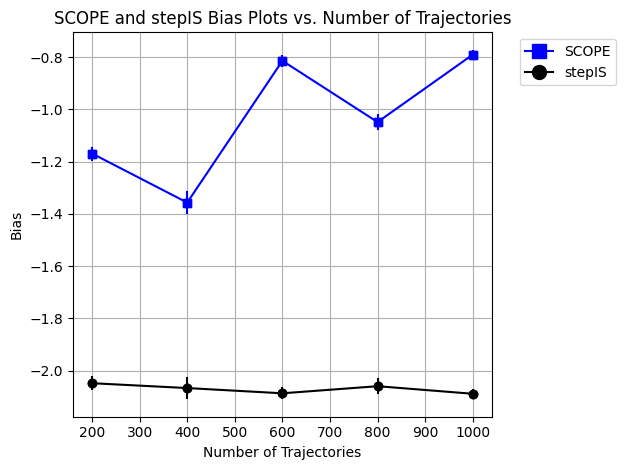

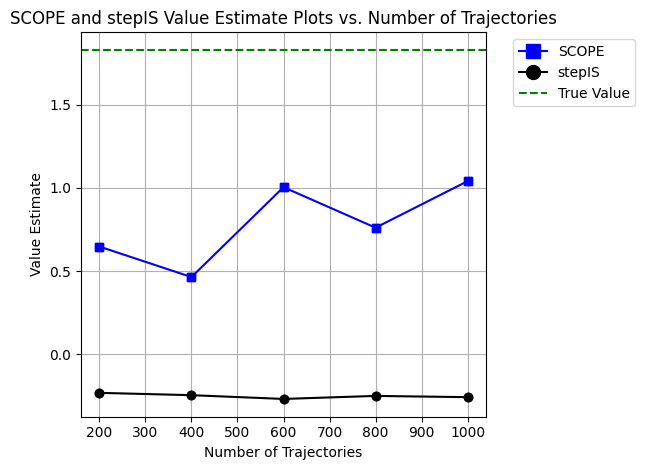

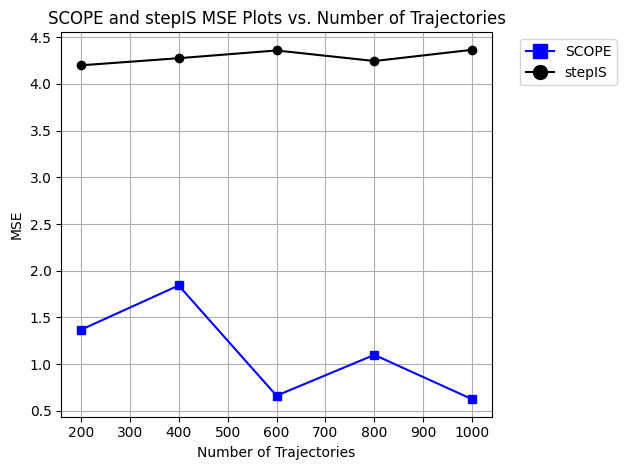

In [43]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.8194792174598249, 1.8396206491517841, 1.7524484458411864, 1.815226748491371, 1.8083530399363912]
Optimal Beta:  [-0.05037838]
SCOPE Results:  {'std_devs_list': [0.043566598304477754, 0.043262008398219864, 0.04270609977175388, 0.04463848185282586, 0.0454826174430524], 'mean_list': [0.5611611803210854, 0.5599398275299152, 0.5617451670708711, 0.5637150827336392, 0.5616834254005489]}
IS Results:  {'std_devs_list': [0.048030258934601534, 0.048321469829586225, 0.047197997079626526, 0.04874940000196815, 0.04986534890375929], 'mean_list': [-0.24663566926655262, -0.24827977071319604, -0.24624831609248912, -0.24516383683854245, -0.24635250143061807]}
Trajectories:  400
True Val:  [1.851978689221787, 1.843171391156719, 1.8059859481425748, 1.8044358659175994, 1.7749448081358439]
Optimal Beta:  [-0.08128465]
SCOPE Results:

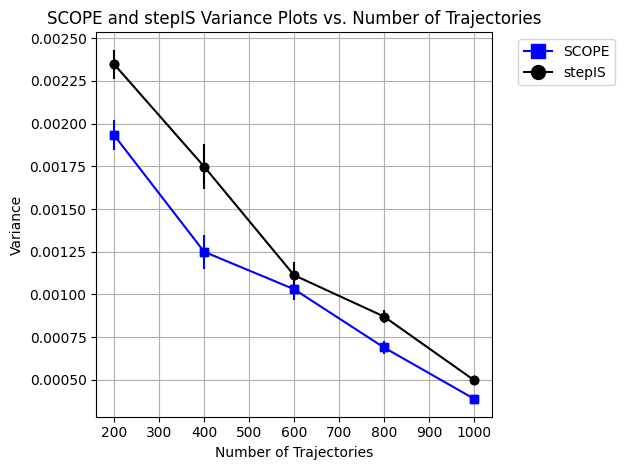

<Figure size 640x480 with 0 Axes>

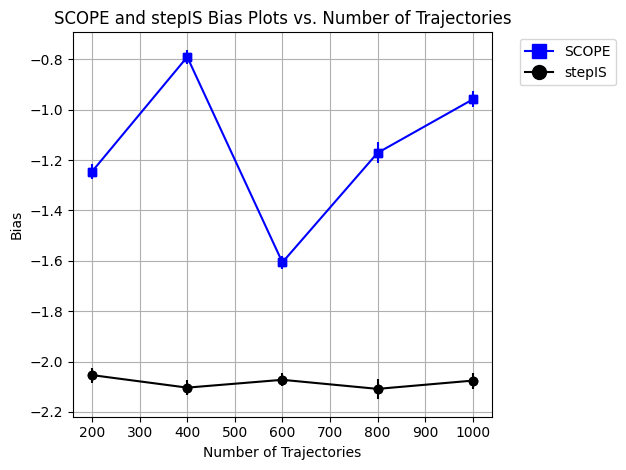

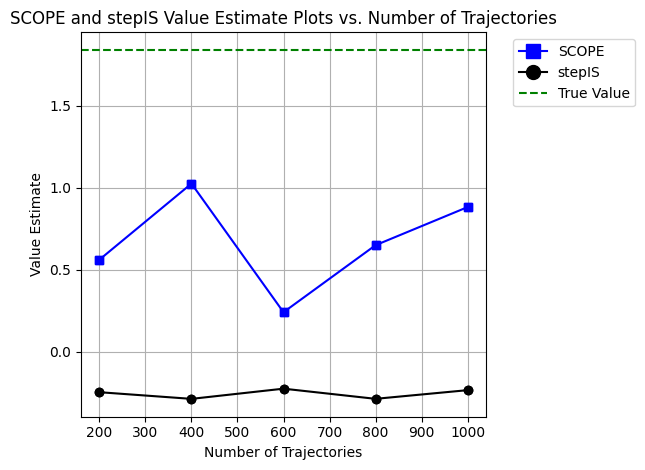

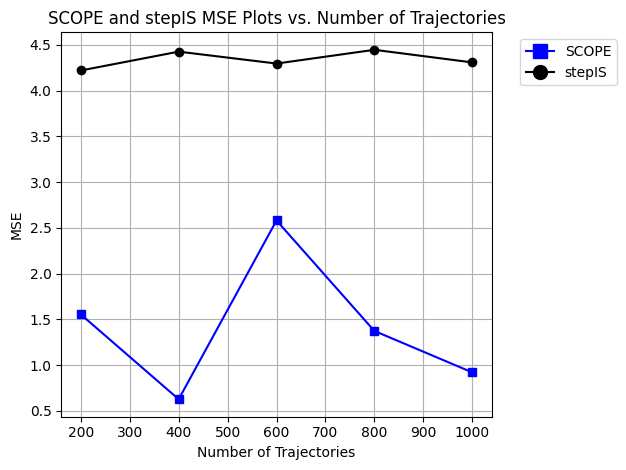

In [45]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.4, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.789030287330813, 1.8006603155068512, 1.8100632827731928, 1.7334737894225496, 1.7935960455754854]
Optimal Beta:  [-0.05291275]
SCOPE Results:  {'std_devs_list': [0.04013873934998515, 0.04063646100594105, 0.04043956599364138, 0.03975766374718389, 0.039704952474496825], 'mean_list': [0.6127160857842385, 0.6130966953139229, 0.610746628869141, 0.6170512582095499, 0.6095577031419279]}
IS Results:  {'std_devs_list': [0.04385719441516799, 0.04540415202493036, 0.045289037281088254, 0.04394991936085523, 0.043346193846348975], 'mean_list': [-0.23256725152458443, -0.23268194769264153, -0.23509765545232647, -0.2272862684464333, -0.2364781960473232]}
Trajectories:  400
True Val:  [1.8733653108060124, 1.82549226607876, 1.8749110229992403, 1.840075637055709, 1.8218169977656635]
Optimal Beta:  [-0.07674999]
SCOPE Results:  {'s

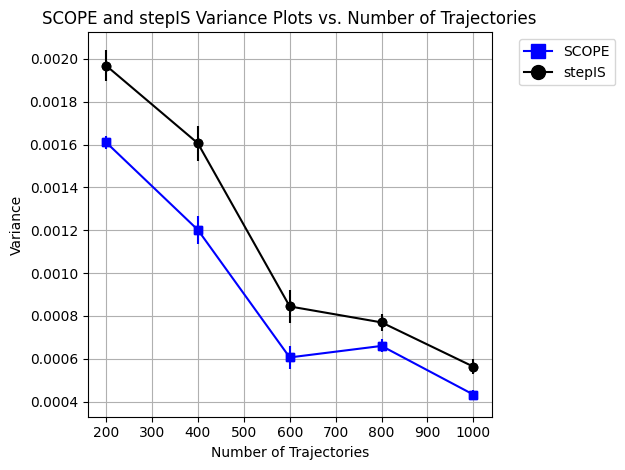

<Figure size 640x480 with 0 Axes>

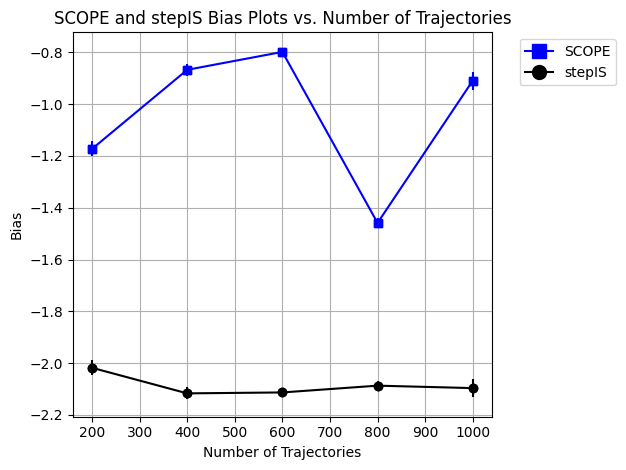

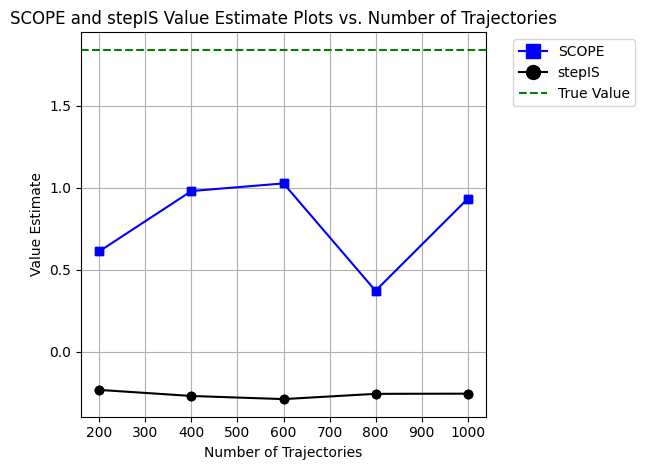

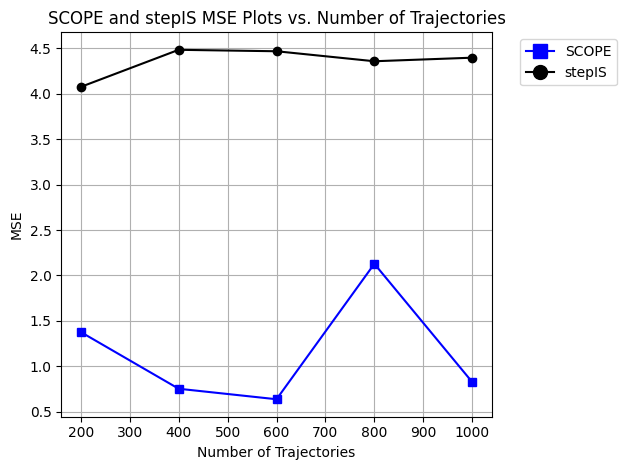

In [46]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.35, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.831220035965966, 1.8323841066188087, 1.7486346160511559, 1.8220707632739106, 1.8048267021950402]
Optimal Beta:  [-0.04950888]
SCOPE Results:  {'std_devs_list': [0.04410701150876861, 0.042627220529508285, 0.044915676257369426, 0.04672179843785855, 0.04519265499000249], 'mean_list': [0.5701037884475161, 0.5708237533282174, 0.5722071509500258, 0.5702119662619428, 0.5665498163606257]}
IS Results:  {'std_devs_list': [0.04820967921320739, 0.046433950141330824, 0.04882873342526506, 0.05169791875925534, 0.04978007466363434], 'mean_list': [-0.22504213753394, -0.22296488356912328, -0.221845891773689, -0.22422815734818696, -0.22715516335438019]}
Trajectories:  400
True Val:  [1.851737365078137, 1.844492393545715, 1.803845011577948, 1.8038747020485515, 1.7737148914346372]
Optimal Beta:  [-0.06934068]
SCOPE Results:  {'std

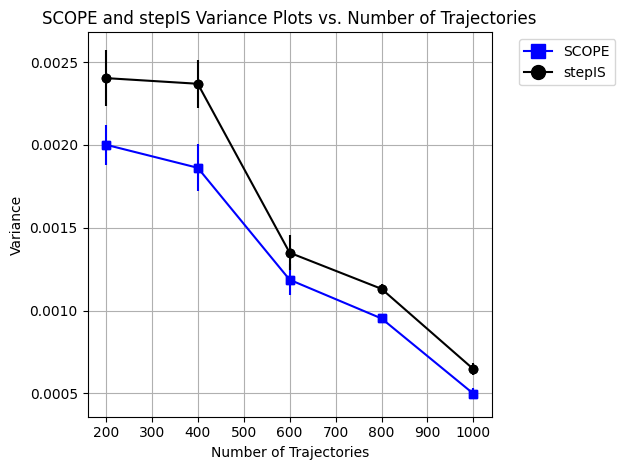

<Figure size 640x480 with 0 Axes>

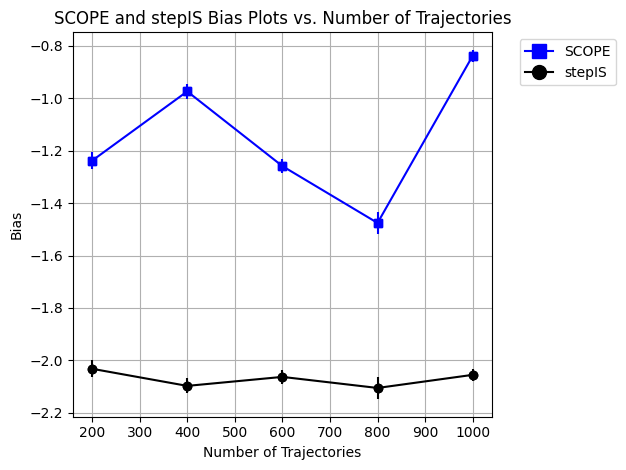

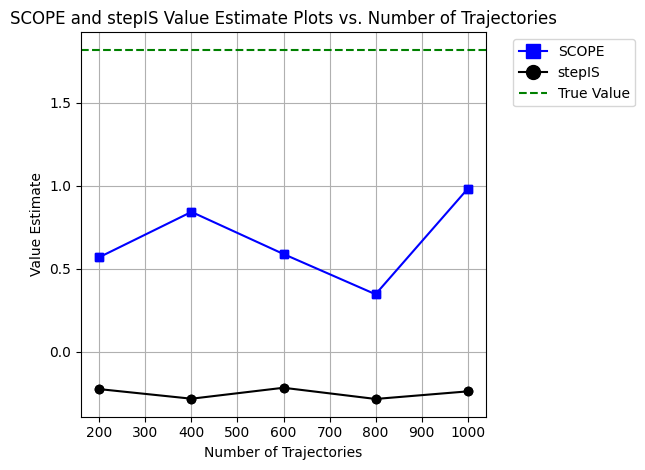

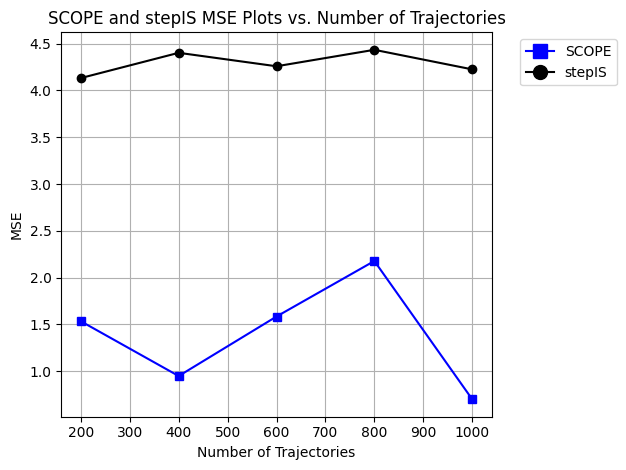

In [47]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.5, 0.001)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.789030287330813, 1.8006603155068512, 1.8100632827731928, 1.7334737894225496, 1.7935960455754854]
Optimal Beta:  [-0.05291275]
SCOPE Results:  {'std_devs_list': [0.04013873934998515, 0.04063646100594105, 0.04043956599364138, 0.03975766374718389, 0.039704952474496825], 'mean_list': [0.6127160857842385, 0.6130966953139229, 0.610746628869141, 0.6170512582095499, 0.6095577031419279]}
IS Results:  {'std_devs_list': [0.04385719441516799, 0.04540415202493036, 0.045289037281088254, 0.04394991936085523, 0.043346193846348975], 'mean_list': [-0.23256725152458443, -0.23268194769264153, -0.23509765545232647, -0.2272862684464333, -0.2364781960473232]}
Trajectories:  400
True Val:  [1.8733653108060124, 1.82549226607876, 1.8749110229992403, 1.840075637055709, 1.8218169977656635]
Optimal Beta:  [-0.07674999]
SCOPE Results:  {'s

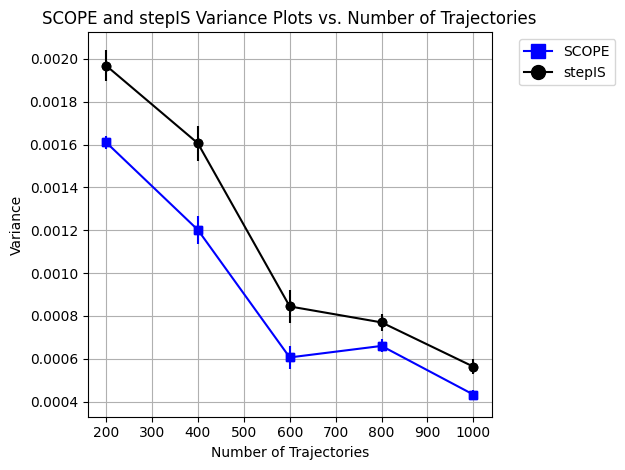

<Figure size 640x480 with 0 Axes>

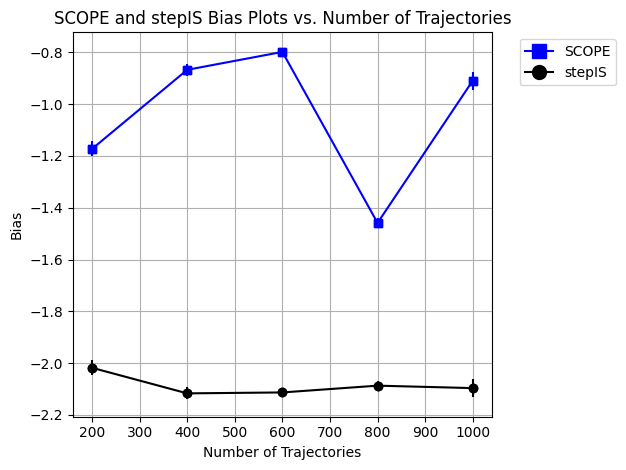

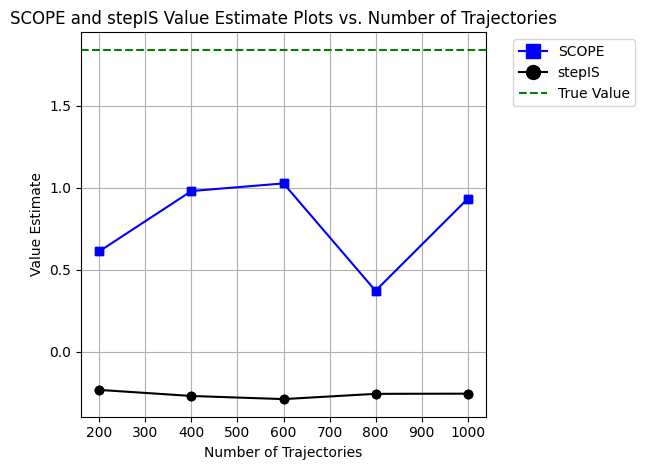

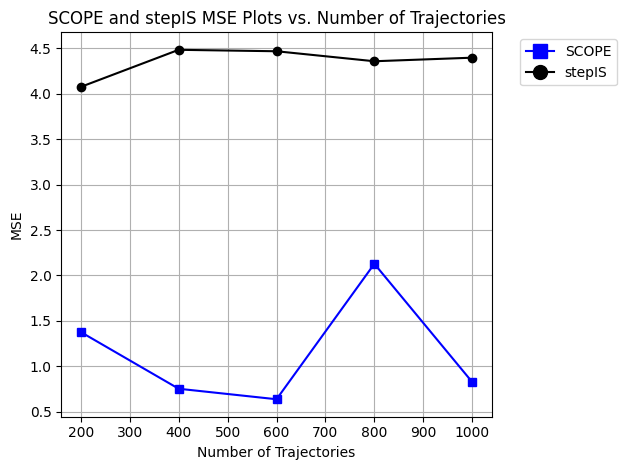

In [48]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.35, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.832277947013725, 1.8079517559233182, 1.7862337337972285, 1.7815298470363885, 1.779074888049967]
Optimal Beta:  [-0.04069083]
SCOPE Results:  {'std_devs_list': [0.04019495686198673, 0.042895336117205314, 0.04089171004978452, 0.03997497457632109, 0.041587742273448094], 'mean_list': [0.3709062998031659, 0.36548016735661293, 0.36854599994046694, 0.36961679951662074, 0.3671747277056877]}
IS Results:  {'std_devs_list': [0.04396896861515214, 0.04647636480596305, 0.044343412019588524, 0.04301509916316063, 0.04456489607607346], 'mean_list': [-0.27801948981657226, -0.28402691008362346, -0.28073955791987276, -0.27898458316038005, -0.282255083327344]}
Trajectories:  400
True Val:  [1.7583093295886263, 1.820277440696942, 1.8285996980501775, 1.7269538019934763, 1.843754042086369]
Optimal Beta:  [-0.04820825]
SCOPE Results: 

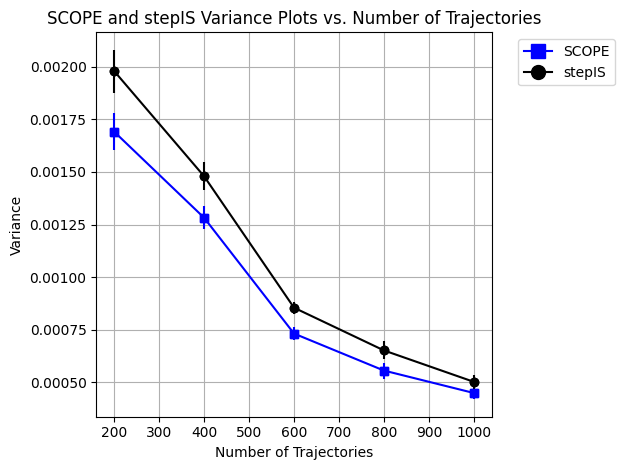

<Figure size 640x480 with 0 Axes>

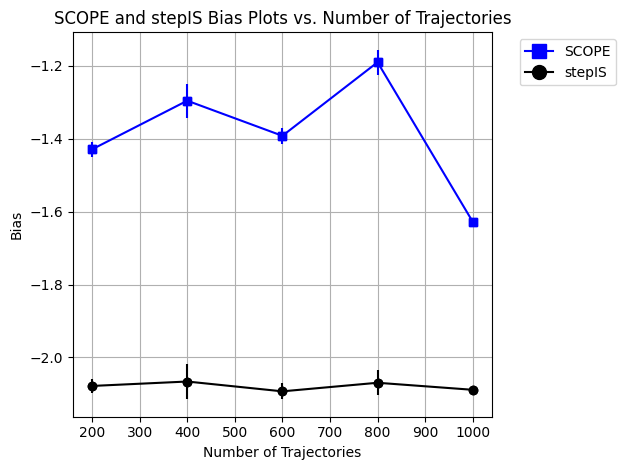

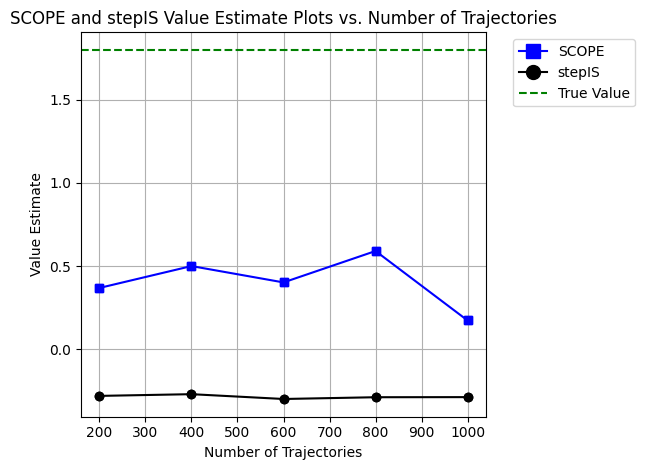

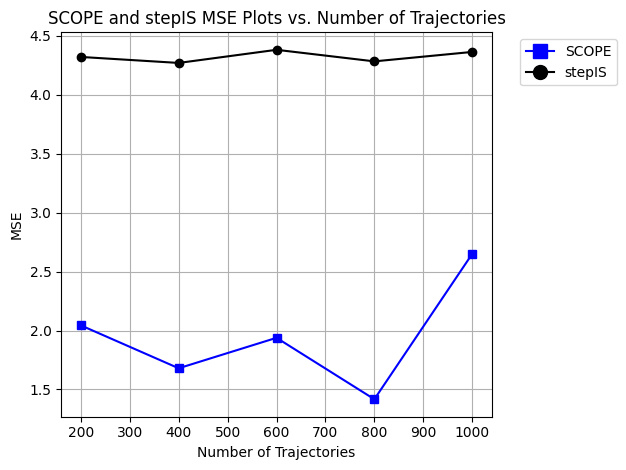

In [49]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), 0), ((3, 3), 0)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.869343212336996, 1.8572730090276182, 1.8540412594035665, 1.8245647815473316, 1.8404774356563753]
Optimal Beta:  [-0.00595663]
SCOPE Results:  {'std_devs_list': [0.0613219210849075, 0.0642070101299075, 0.06510105024833256, 0.06106451226052002, 0.06197862410003102], 'mean_list': [-0.1565589011076156, -0.1608025974804675, -0.15859151080868736, -0.15574908564570003, -0.15891199056012723]}
IS Results:  {'std_devs_list': [0.06172247775554, 0.0646266896157227, 0.06548789267422139, 0.06141194761093059, 0.062350173591962585], 'mean_list': [-0.25155347028422426, -0.2558822598787652, -0.25363874552820714, -0.2506961657283997, -0.25398034212877135]}
Trajectories:  400
True Val:  [1.7883600121665595, 1.8771204576083997, 1.8536644522882488, 1.785020001094367, 1.886893891090277]
Optimal Beta:  [-0.02119164]
SCOPE Results:  {

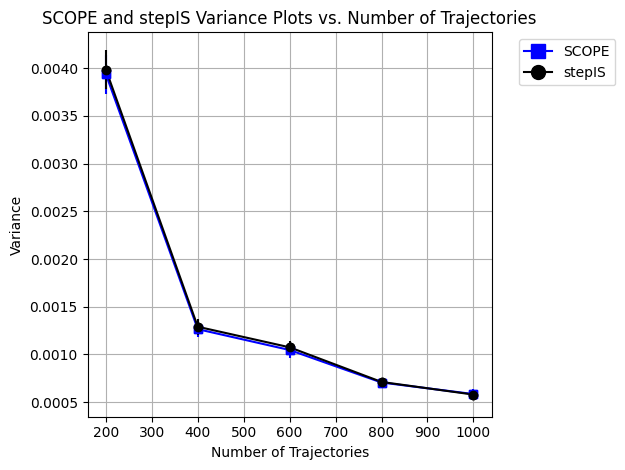

<Figure size 640x480 with 0 Axes>

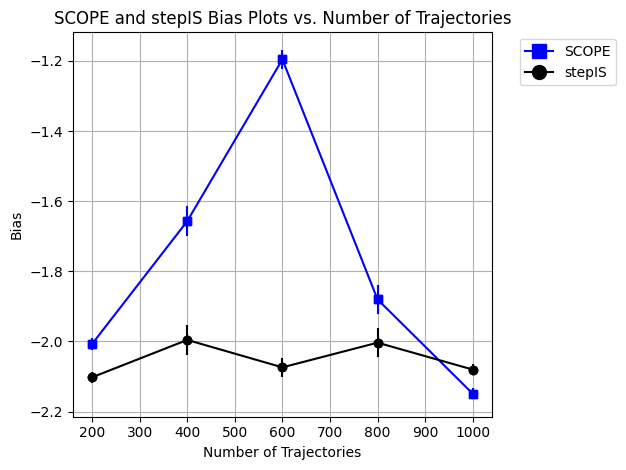

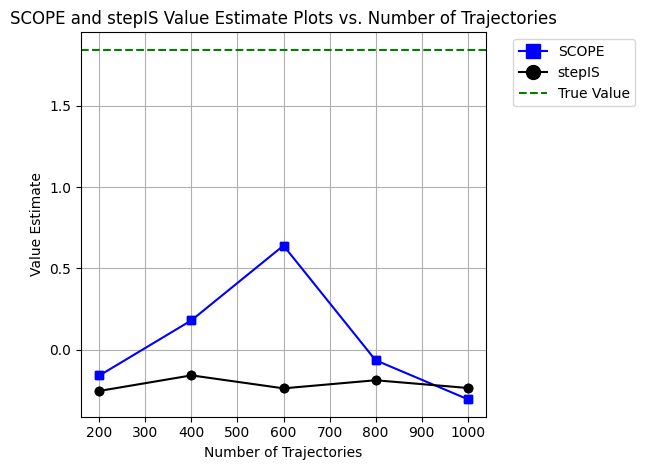

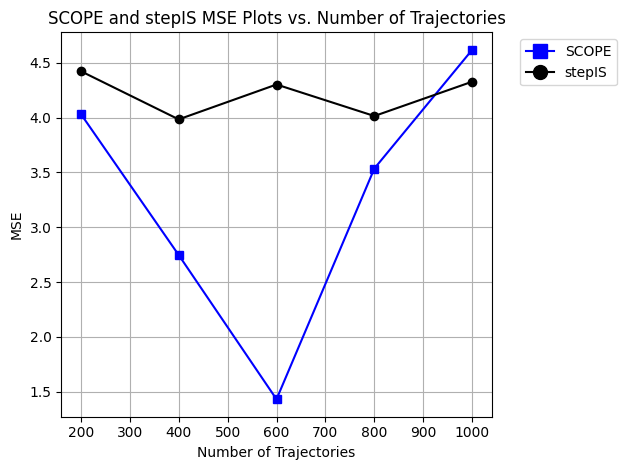

In [50]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), 0), ((2, 2), -1)]
good_cluster_1 = [((3, 2), 1), ((4, 2), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.8419510113799338, 1.8269412512161, 1.8234527323476413, 1.7978656268159603, 1.810690777147904]
Optimal Beta:  [0.00311283]
SCOPE Results:  {'std_devs_list': [0.07287198228136413, 0.07597043311725518, 0.07566565317265293, 0.07058969139532266, 0.07257589179637514], 'mean_list': [-0.3350682688239492, -0.33827544198900444, -0.3379913987172513, -0.33438769458486856, -0.3374577737114574]}
IS Results:  {'std_devs_list': [0.07273900844430826, 0.07583238456746998, 0.07553376824664956, 0.07048860499723258, 0.07246096126893271], 'mean_list': [-0.28542573614295114, -0.28858844104971276, -0.2883213439267496, -0.2847699788899024, -0.2877766836177603]}
Trajectories:  400
True Val:  [1.7621984489516465, 1.8504392402836325, 1.8202562268724587, 1.7555143868477598, 1.8567101272919937]
Optimal Beta:  [-0.0131078]
SCOPE Results:  {

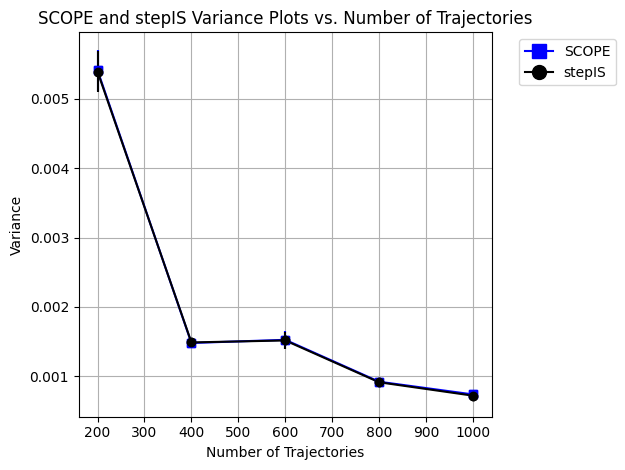

<Figure size 640x480 with 0 Axes>

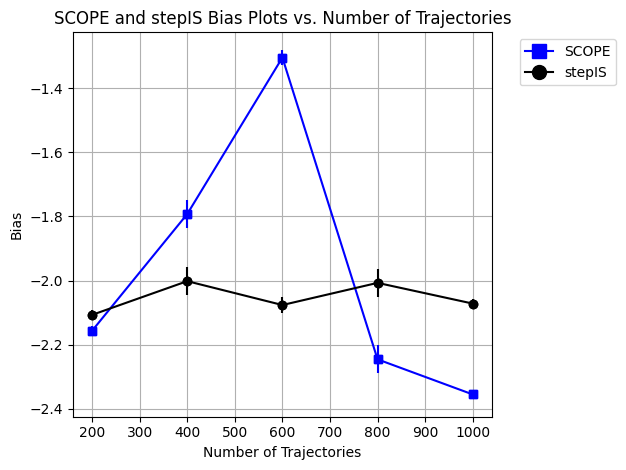

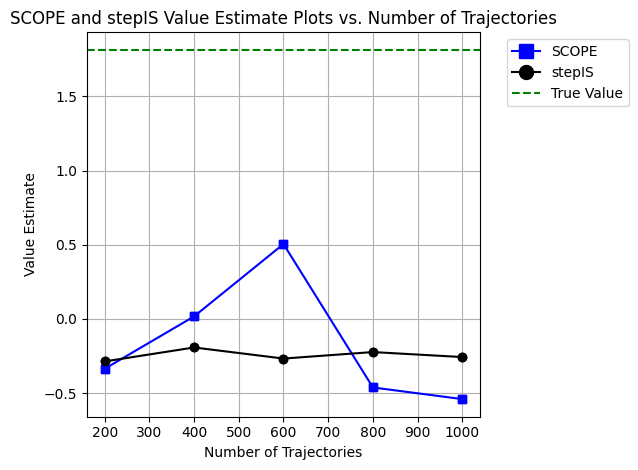

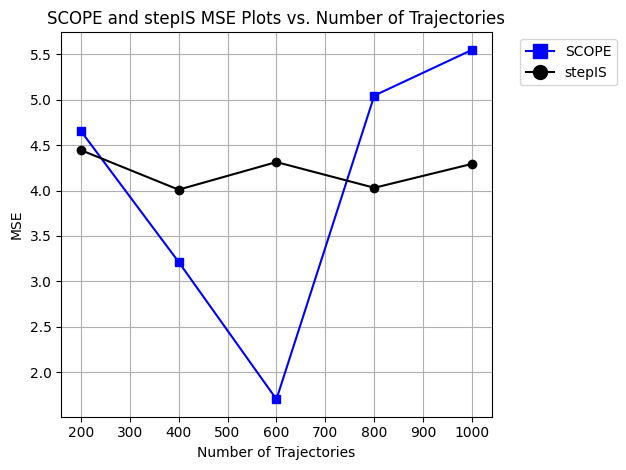

In [51]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), -0.2), ((2, 2), -1)]
good_cluster_1 = [((3, 2), 1), ((4, 2), 0.2)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [2.1234109358808384, 2.100530465565776, 2.105191592344625, 2.0866701424095275, 2.1221231668569702]
Optimal Beta:  [0.00057696]
SCOPE Results:  {'std_devs_list': [0.08758003900492271, 0.08631478382630328, 0.08058720310156318, 0.08219612743100872, 0.08651386451404647], 'mean_list': [0.06607221229302973, 0.057846128230781675, 0.06126778644514531, 0.05925307511841291, 0.06077965053056335]}
IS Results:  {'std_devs_list': [0.08758112588248991, 0.0863241573385629, 0.08058751135860441, 0.08220406134911089, 0.08651837787264796], 'mean_list': [0.07527338219322523, 0.06705554025678397, 0.0704740575275706, 0.06844964522700715, 0.06998796699009004]}
Trajectories:  400
True Val:  [2.0615613851496617, 2.1262300046125135, 2.1350968098993643, 2.024422847183223, 2.1635277996490463]
Optimal Beta:  [-0.0436785]
SCOPE Results:  {'std

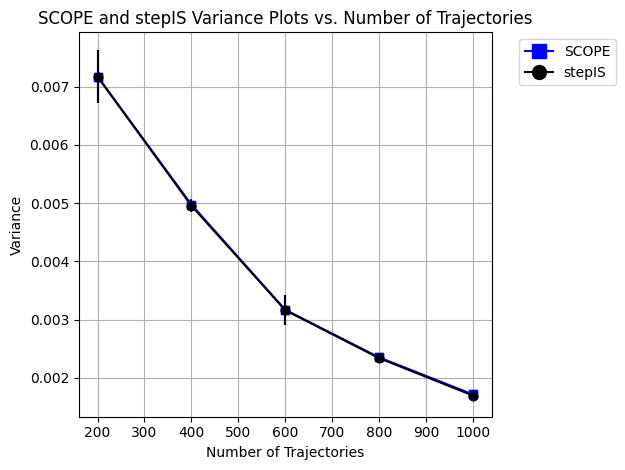

<Figure size 640x480 with 0 Axes>

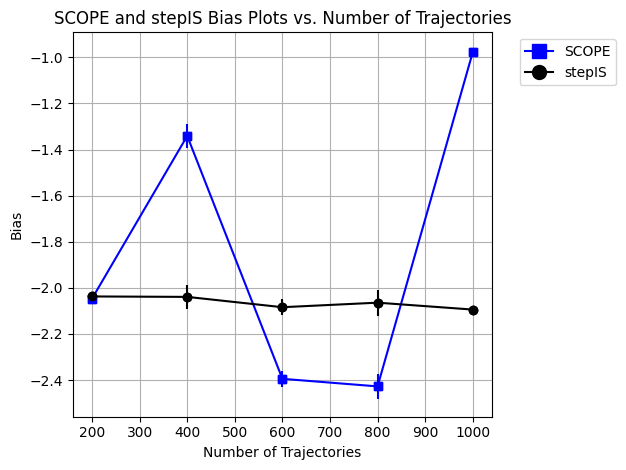

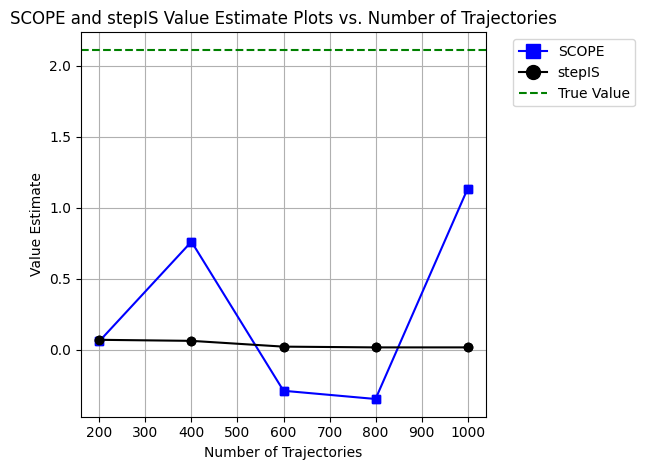

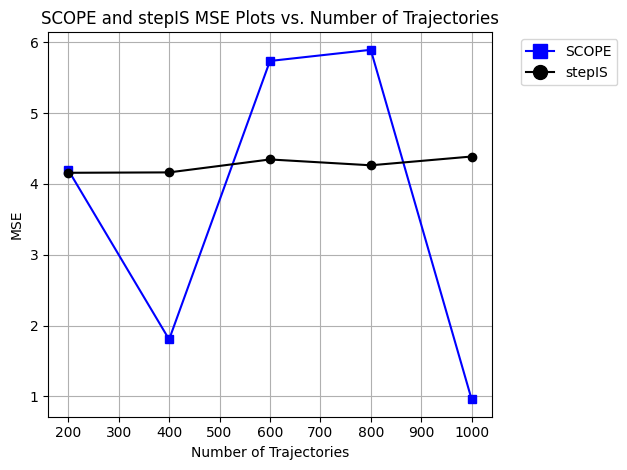

In [52]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -0.2), ((2, 4), -1)]
good_cluster_1 = [((3, 2), 1), ((4, 2), 0.2)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.7915243003610082, 1.808285368033887, 1.851358911871073, 1.7219451288507222, 1.7880297919034298]
Optimal Beta:  [-0.04256519]
SCOPE Results:  {'std_devs_list': [0.07048495909107007, 0.06429252627085746, 0.06854313483503094, 0.06978112568912123, 0.06775933195440006], 'mean_list': [0.500676595914828, 0.4908775558030443, 0.49773776967810107, 0.4974620905684132, 0.49391584729657084]}
IS Results:  {'std_devs_list': [0.07055041073155242, 0.06418572096252581, 0.06809969172985514, 0.07000691231186777, 0.06801720657752992], 'mean_list': [-0.1793040757956537, -0.18950156017598824, -0.18269415087358745, -0.1817577321644031, -0.1866702161333152]}
Trajectories:  400
True Val:  [1.886265301484521, 1.8133700177814571, 1.8807616042430007, 1.8210345211147478, 1.821669149244302]
Optimal Beta:  [-0.06293921]
SCOPE Results:  {'std

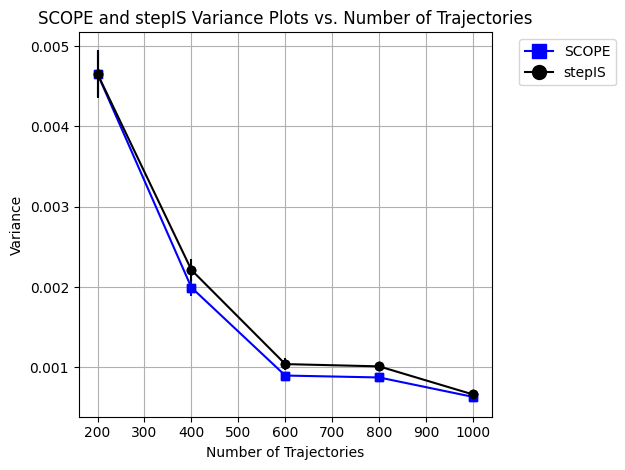

<Figure size 640x480 with 0 Axes>

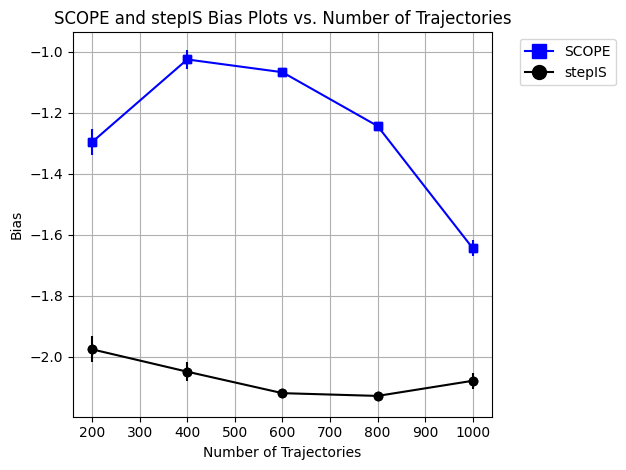

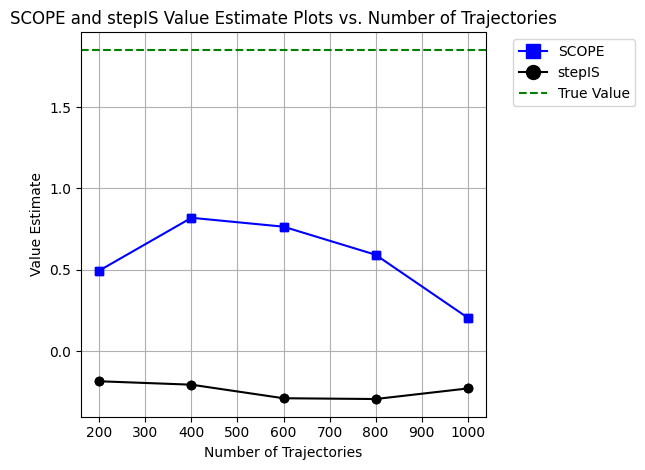

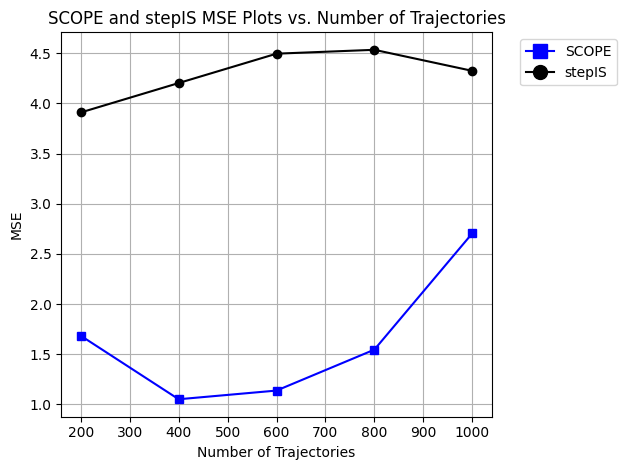

In [53]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), 0), ((3, 3), 0)]
good_cluster_1 = [((4, 0), 0), ((4, 1), 1)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.35, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.5753062304324372, 1.592327062520194, 1.6327688837596281, 1.5163042036432106, 1.5594197786329214]
Optimal Beta:  [-0.0341998]
SCOPE Results:  {'std_devs_list': [0.07372168775702517, 0.06519109495571578, 0.06707694128393138, 0.07106209619716972, 0.07019733595153006], 'mean_list': [0.1496166532551216, 0.13974748248847602, 0.14742798924072292, 0.1491131681705865, 0.1420900533335877]}
IS Results:  {'std_devs_list': [0.07547854563132815, 0.06744048827904531, 0.06887755340069854, 0.07314283197241019, 0.07226434963432615], 'mean_list': [-0.39672651840343737, -0.4069158266599643, -0.3992777467279245, -0.3966186851654012, -0.4047395316096947]}
Trajectories:  400
True Val:  [1.6486159429816327, 1.6176535758274062, 1.6614286022742313, 1.5842928684376942, 1.6048673230851978]
Optimal Beta:  [-0.07590671]
SCOPE Results:  {'s

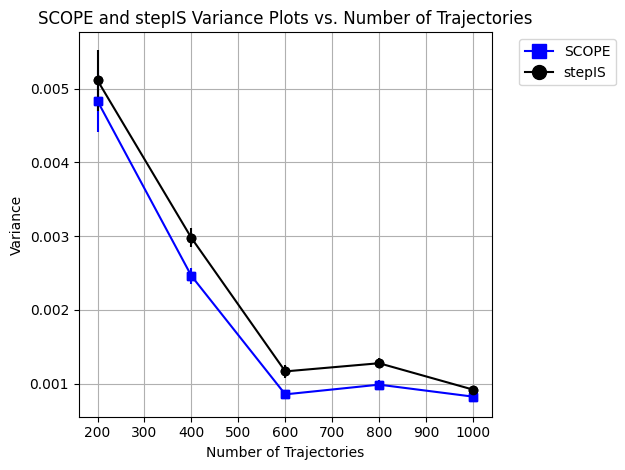

<Figure size 640x480 with 0 Axes>

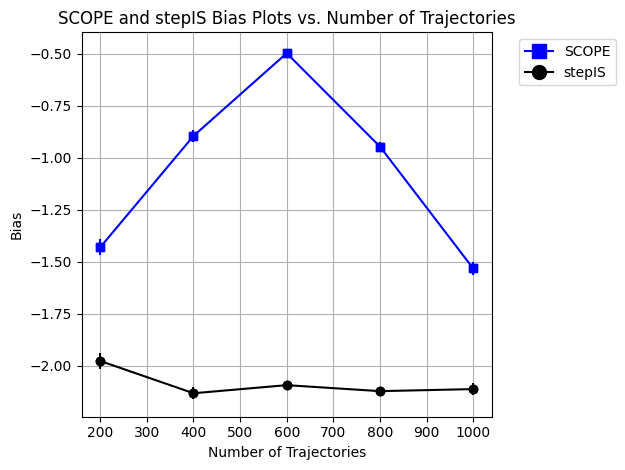

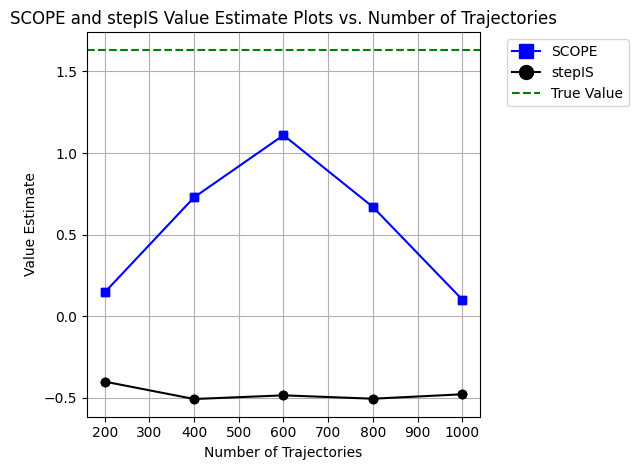

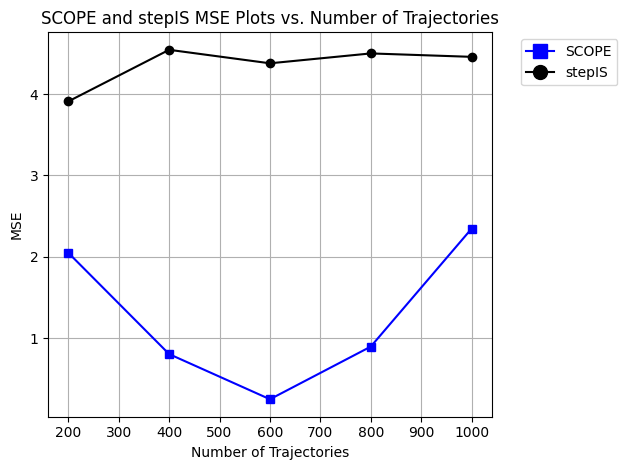

In [54]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), 0), ((3, 1), 0), ((2, 2), -1)]
good_cluster_1 = [((4, 0), 0), ((4, 1), 1)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.35, 0.0)

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Trajectories:  200
True Val:  [1.950968852237566, 1.9083876321444295, 1.8970683134335116, 1.8990601721150433, 1.889050245231944]
Optimal Beta:  [0.04543]
SCOPE Results:  {'std_devs_list': [0.1091522253772177, 0.11042565742271285, 0.10253910265232302, 0.10564437122386539, 0.10656237983779283], 'mean_list': [-0.8938660208192558, -0.8886845864632626, -0.8983193531427298, -0.8945115674560545, -0.894049122604612]}
IS Results:  {'std_devs_list': [0.11126836364197107, 0.11281105646046123, 0.10481145292662569, 0.1083635349261622, 0.10908990645833923], 'mean_list': [-0.1693613292936344, -0.16353090585473798, -0.17341299199271223, -0.17036906580751368, -0.16898170744494537]}
Trajectories:  400
True Val:  [1.8800206977306941, 1.9413171550240873, 1.905216430600868, 1.841548583306825, 1.9530031501117004]
Optimal Beta:  [0.04041925]
SCOPE Results:  {'std_d

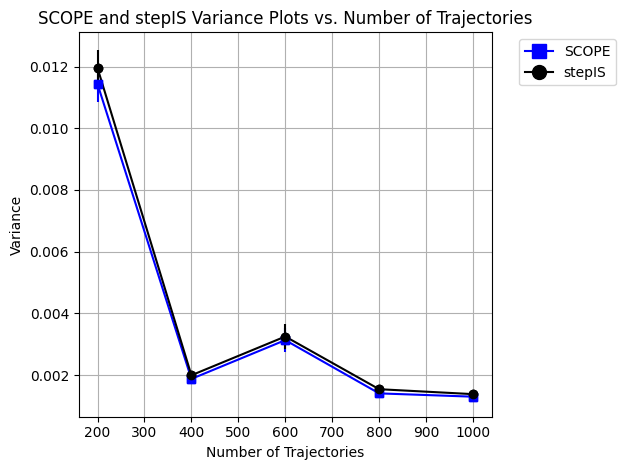

<Figure size 640x480 with 0 Axes>

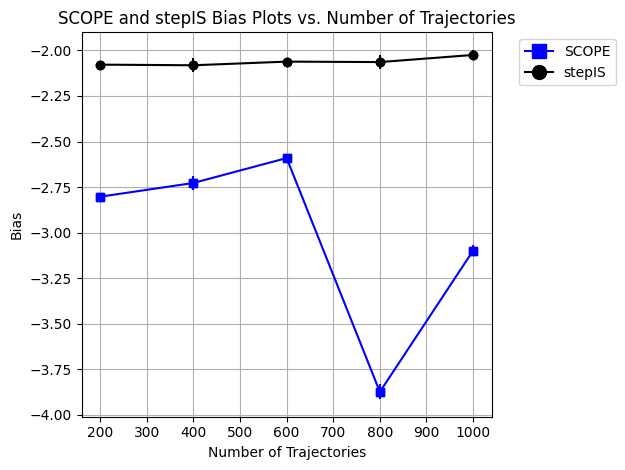

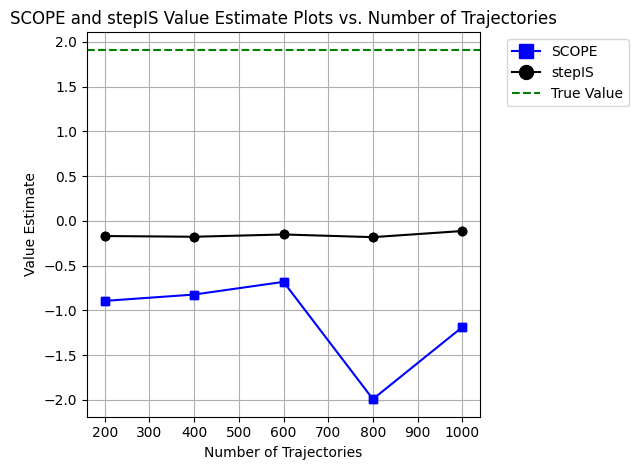

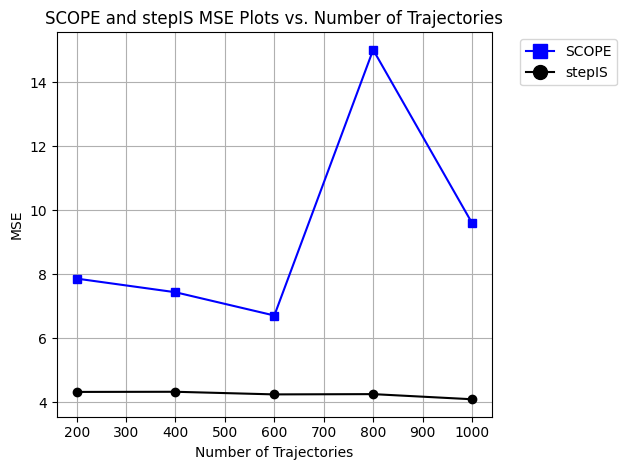

In [55]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((1, 1), 0), ((1, 2), 0), ((2, 1), -1)]
good_cluster_1 = [((4, 1), 0), ((4, 2), 1)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0)

## Sparse 1 bad, 1 good, larger

In [56]:
np.random.seed(42)
# Gridworld environment
height = 10
width  = 10
start = (0,0)
end = (9,9)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

In [57]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
good_cluster_1 = [((4, 0), 1), ((4, 1), 0)]


env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.001)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.001)

Loading  200  trajectories: 


KeyboardInterrupt: ignored

## Dense 2 bad

## Sparse 2 bad, sparse environment

In [59]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.04293881]
Variance Scope: 0.004942628787659489
----------
Var SCOPE_phi:  0.006516996595317605
Var IS_phi:  0.007193150442090013
Percent change in variance:  -9.399968097649678
SCOPE results:  {'std_devs_list': [0.05430902976111042, 0.057890452686573654, 0.05606982406750512, 0.05277230611819157, 0.056163587341848016], 'mean_list': [-0.15985993575342683, -0.16425471071719205, -0.1634131503193509, -0.16159094157069917, -0.16345638099396154]}
IS results:  {'std_devs_list': [0.05598085842624912, 0.06003037162659606, 0.05824769411750717, 0.055198303202568424, 0.058427297869175596], 'mean_list': [-0.8446358709865328, -0.849644047231752, -0.8485687293227706, -0.8460245478793541, -0.8487641824900308]}
true eval:  1.2094139385940283
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.03503817]
Variance Scope: 0.00579270196775333
----------
Var SCOPE_phi:  0.005962907267656461
Var IS_phi:  0.006068729342516566
Percent change in variance:  -1.74

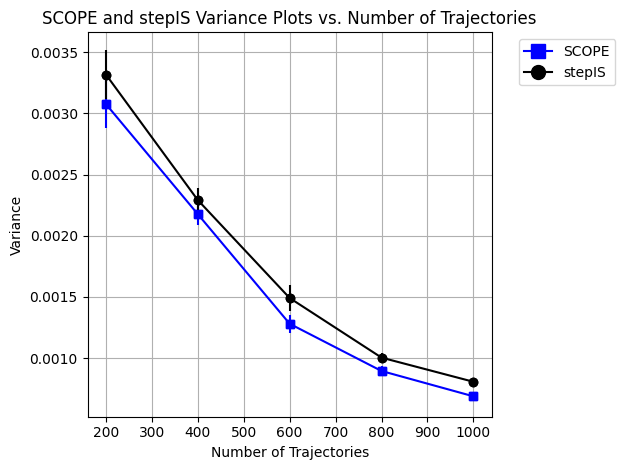

<Figure size 640x480 with 0 Axes>

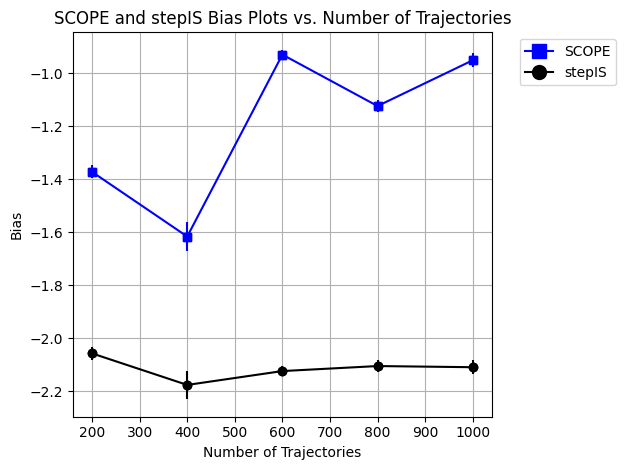

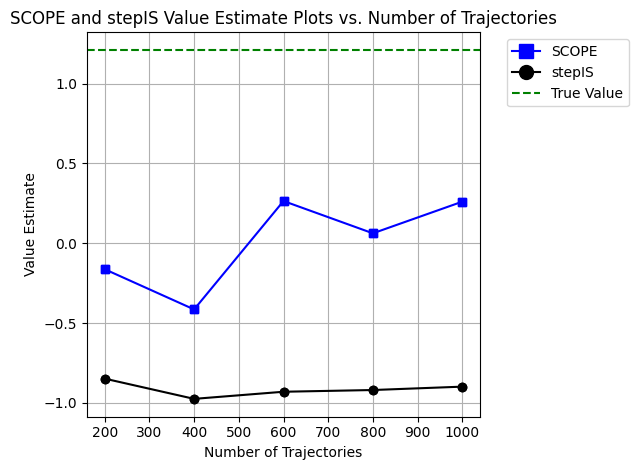

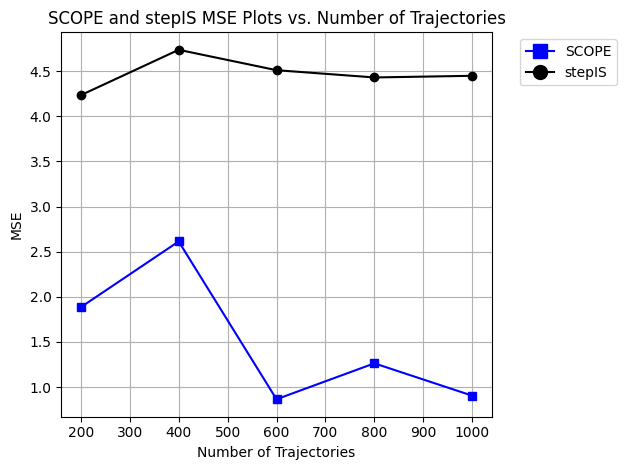

In [61]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_2 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.04529835]
Variance Scope: 0.009238263584941772
----------
Var SCOPE_phi:  0.009788893430071622
Var IS_phi:  0.010642175140523236
Percent change in variance:  -8.017925839262787
SCOPE results:  {'std_devs_list': [0.05126634307239191, 0.053839521821323726, 0.05080817832109381, 0.05158303516814778, 0.052884798559403146], 'mean_list': [0.09973415834234098, 0.09711849709357086, 0.09733923215575738, 0.10387642883101023, 0.09628568591502266]}
IS results:  {'std_devs_list': [0.05564811587918362, 0.05863046376720312, 0.05517353852727016, 0.0559867147108773, 0.057268102099800954], 'mean_list': [-0.6226710533574529, -0.6259338230394872, -0.6254664852045787, -0.6181676425505934, -0.626680618750401]}
true eval:  1.3789109440671201
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.0552277]
Variance Scope: 0.0039593692503152875
----------
Var SCOPE_phi:  0.004637027169675454
Var IS_phi:  0.005624476097297326
Percent change in variance:  -17.556282

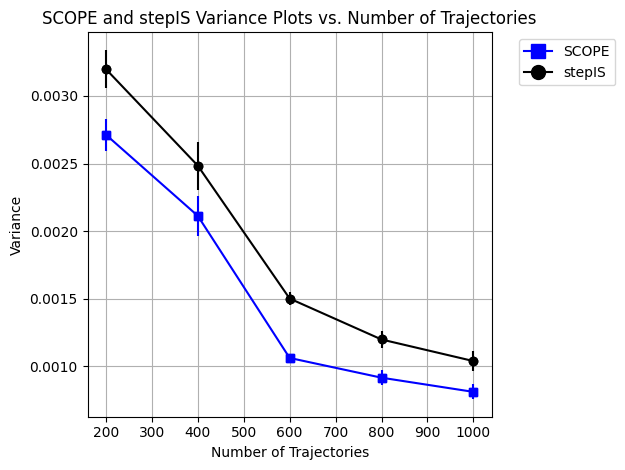

<Figure size 640x480 with 0 Axes>

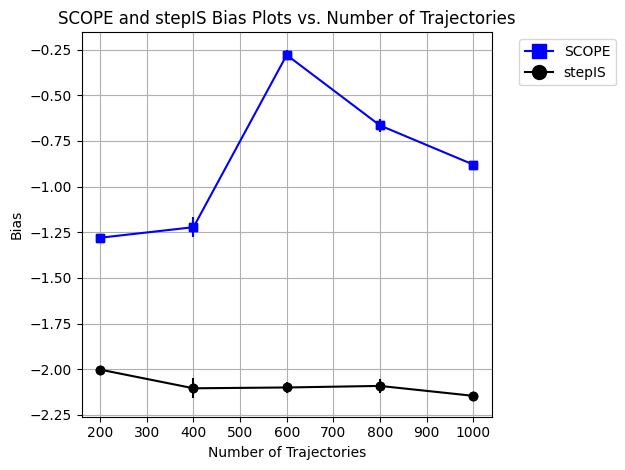

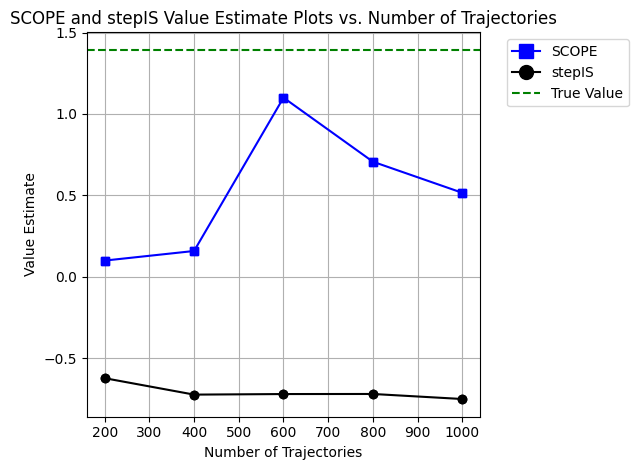

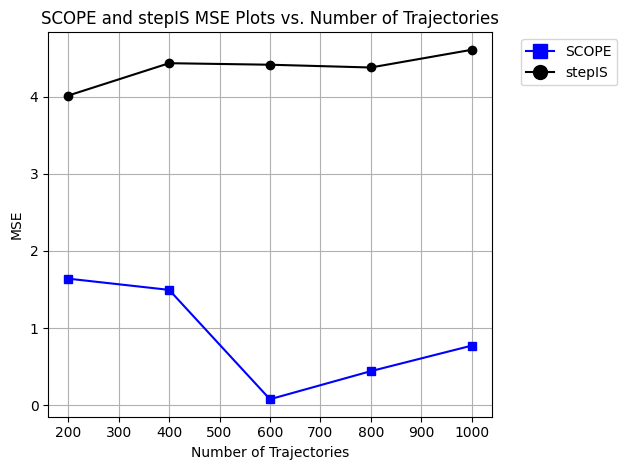

In [63]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_2 = [((1, 2), -1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
# eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
# behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

In [ ]:
#Seeds removed from SCOPE and IS

np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 2), 0), ((2, 3), -1), ((2, 4), 0)]
bad_cluster_2 = [((3, 1), -1), ((4, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1, bad_cluster_2],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
eval_policy = {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4}
behav_policy = {"up": 0.25, "down": 0.25, "left": 0.25, "right": 0.25}
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy, eval_policy, num_trajectories, 0.3, 0.0 )

## Sparse 3 bad

### Mid Sparsity

## Sparse 2 good

In [64]:
np.random.seed(42)
# Gridworld environment
height = 5
width  = 5
start = (0,0)
end = (4,4)

# Define the quadrants of the gridworld based on midpoint
mid_x = width // 2
mid_y = height // 2

# Define probability distributions for each quadrant
behav_policy_quad = {
    "top_left": {"up": 0.2, "down": 0.2, "left": 0.2, "right": 0.4},
    "top_right": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.4, "down": 0.2, "left": 0.2, "right": 0.2}
}

# Define probability distributions for each quadrant
eval_policy_quad = {
    "top_left": {"up": 0.1, "down": 0.1, "left": 0.1, "right": 0.7},
    "top_right": {"up": 0.4, "down": 0.1, "left": 0.1, "right": 0.4},
    "bottom_left": {"up": 0.3, "down": 0.2, "left": 0.2, "right": 0.3},
    "bottom_right": {"up": 0.55, "down": 0.15, "left": 0.15, "right": 0.15}
}

Loading  200  trajectories: 
Iteration: 1
Beta: [0.04529793]
Variance Scope: 0.009238263585014655
----------
Var SCOPE_phi:  0.009788892700124483
Var IS_phi:  0.010642175140523236
Percent change in variance:  -8.01793269826604
SCOPE results:  {'std_devs_list': [0.05126637962617692, 0.05383956198751147, 0.05080821460425573, 0.05158307218518995, 0.05288483524941721], 'mean_list': [-0.09972742368267219, -0.09711175640120048, -0.097332493762354, -0.10386969753809061, -0.09627894602453592]}
IS results:  {'std_devs_list': [0.05564811587918362, 0.05863046376720312, 0.05517353852727016, 0.0559867147108773, 0.057268102099800954], 'mean_list': [0.6226710533574529, 0.6259338230394872, 0.6254664852045787, 0.6181676425505934, 0.626680618750401]}
true eval:  2.728499740126576
Loading  400  trajectories: 
Iteration: 1
Beta: [0.05522769]
Variance Scope: 0.003959369250315836
----------
Var SCOPE_phi:  0.0046370271835033455
Var IS_phi:  0.005624476097297326
Percent change in variance:  -17.5562825179125

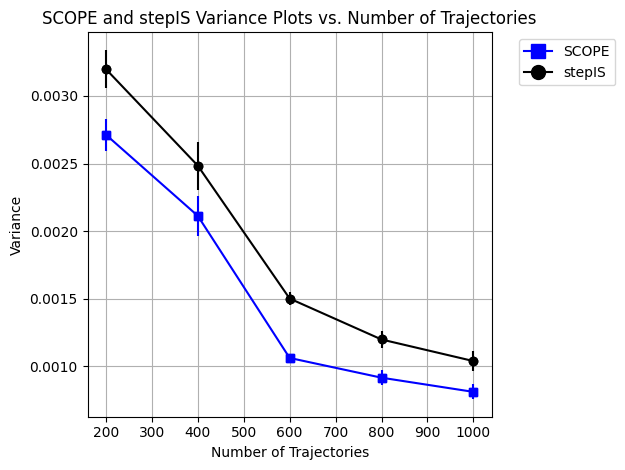

<Figure size 640x480 with 0 Axes>

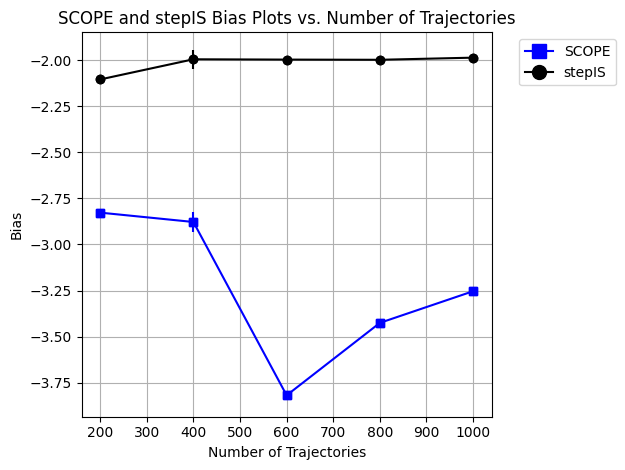

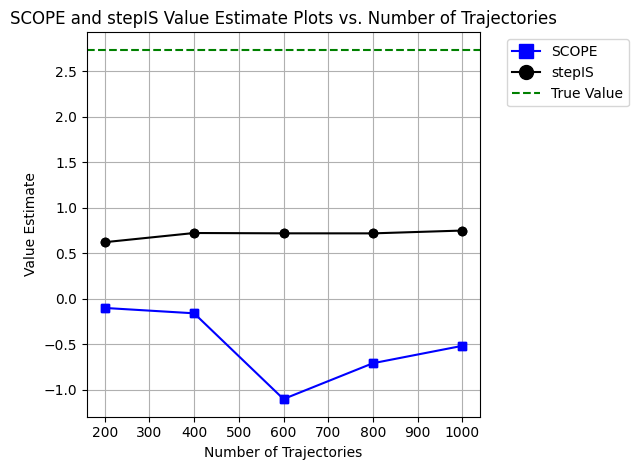

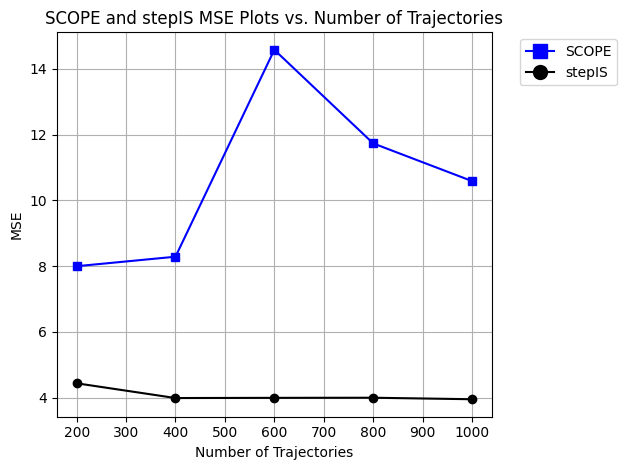

In [65]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), 1),((3, 4), 0)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)

num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [0.03896287]
Variance Scope: 0.014930150086522308
----------
Var SCOPE_phi:  0.019070344969592454
Var IS_phi:  0.019869600730391568
Percent change in variance:  -4.022505392252854
SCOPE results:  {'std_devs_list': [0.06338513284035123, 0.06126896312128554, 0.06414464168657415, 0.05891854623500558, 0.061563438064282855], 'mean_list': [-0.03996362715619426, -0.03705872367857797, -0.039366071564587414, -0.0406785581865322, -0.04003637553811981]}
IS results:  {'std_devs_list': [0.06615939912736324, 0.06395839630683878, 0.06740919842780727, 0.061525162165310704, 0.06444455744815225], 'mean_list': [0.5814051391031847, 0.5848666456649169, 0.5823471851610016, 0.5803795772657513, 0.5818150085625534]}
true eval:  2.700852058786227
Loading  400  trajectories: 
Iteration: 1
Beta: [0.0854978]
Variance Scope: 0.007611992586116893
----------
Var SCOPE_phi:  0.008816245073335194
Var IS_phi:  0.01167494239779765
Percent change in variance:  -24.4857509960

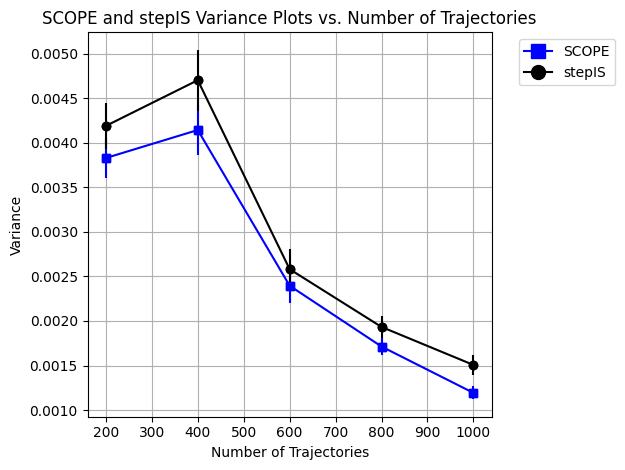

<Figure size 640x480 with 0 Axes>

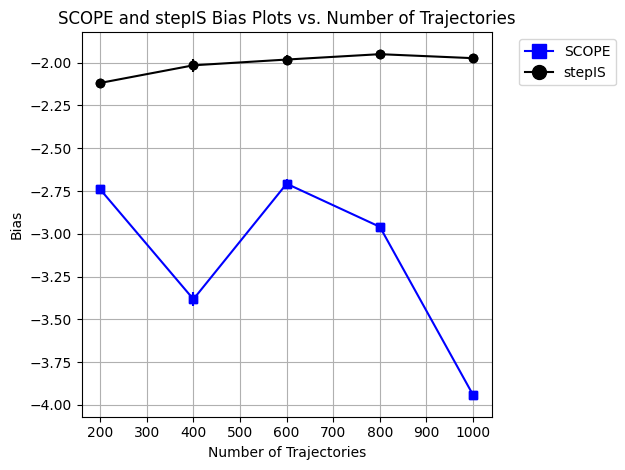

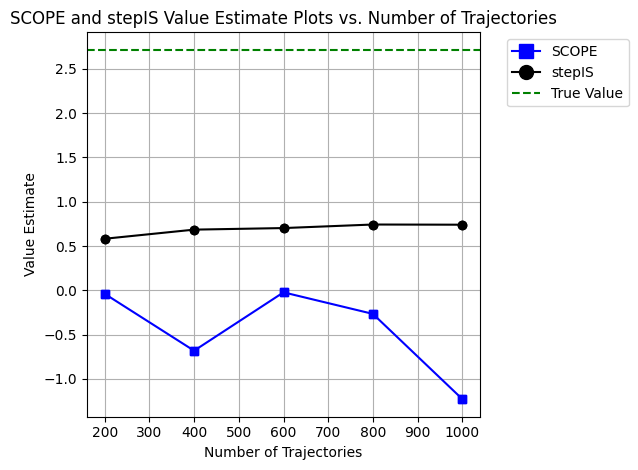

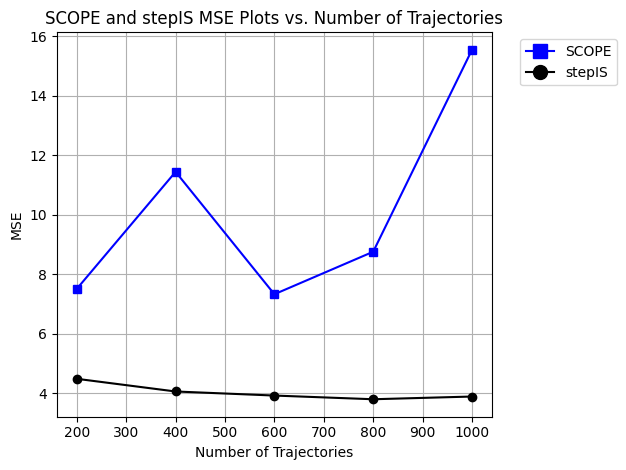

In [67]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1)]
good_cluster_2 = [((1, 2), 1), ((1, 1), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1, good_cluster_2],final_reward = 10, sparsity = 0.0)

num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

## Sparse 1 good

Loading  200  trajectories: 
Iteration: 1
Beta: [0.05300299]
Variance Scope: 0.0037225556835906765
----------
Var SCOPE_phi:  0.004181411158650554
Var IS_phi:  0.006934320943127473
Percent change in variance:  -39.699774600212244
SCOPE results:  {'std_devs_list': [0.0668828448173276, 0.06322694813026204, 0.06184652745744244, 0.06344169008076293, 0.06469244397419449], 'mean_list': [-0.5849020952744017, -0.5896723816142655, -0.5908596019257716, -0.5873222908432486, -0.5861024934705388]}
IS results:  {'std_devs_list': [0.06974437848617344, 0.06662984241023413, 0.0636644804773306, 0.06663251889972856, 0.06708408472076581], 'mean_list': [0.2757817305675225, 0.2707600993040767, 0.27070977600851825, 0.2733286600224178, 0.27449631129281227]}
true eval:  2.2893867221167903
Loading  400  trajectories: 
Iteration: 1
Beta: [0.07402807]
Variance Scope: 0.005382777154601507
----------
Var SCOPE_phi:  0.005705121951883735
Var IS_phi:  0.007415041788692844
Percent change in variance:  -23.060151048866

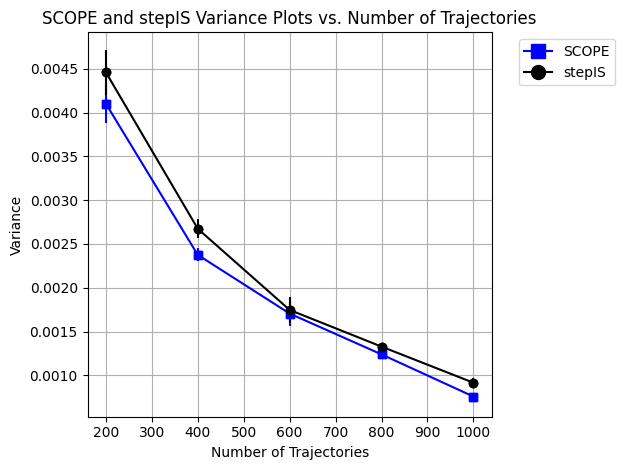

<Figure size 640x480 with 0 Axes>

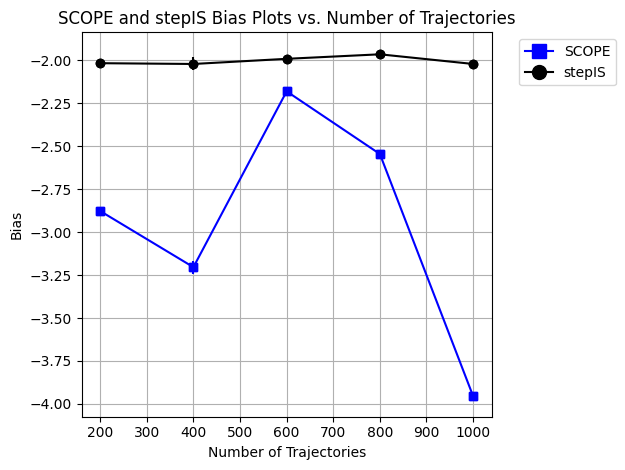

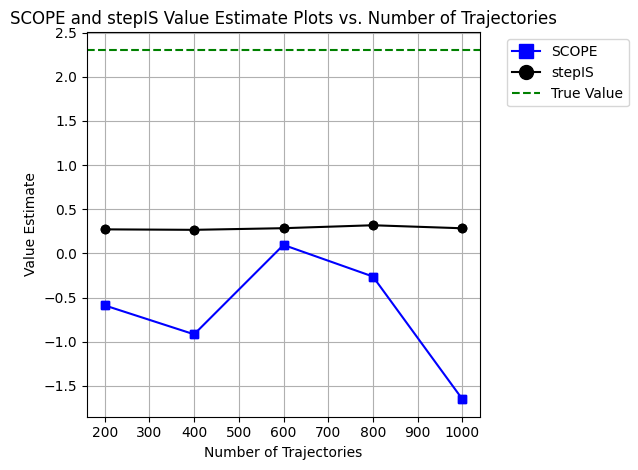

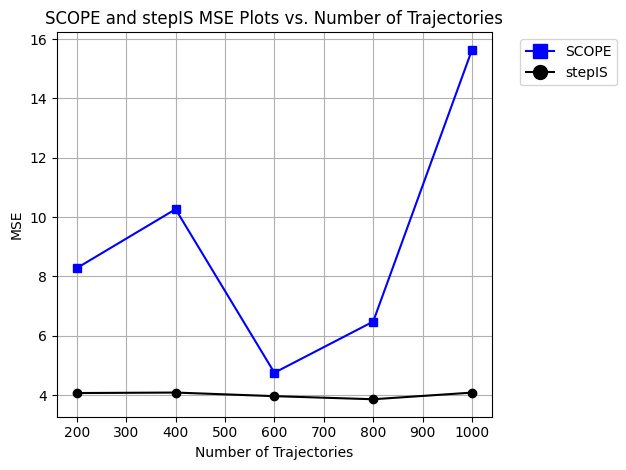

In [45]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 0), ((2, 4), 1)]

env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [0.08689778]
Variance Scope: 0.01318940846688907
----------
Var SCOPE_phi:  0.010584607215188523
Var IS_phi:  0.015360901040530783
Percent change in variance:  -31.093838914394954
SCOPE results:  {'std_devs_list': [0.05749887467364069, 0.056750501895071234, 0.056594012805575494, 0.05810359885731969, 0.057608158596789236], 'mean_list': [-0.8088433360186593, -0.8054585469597164, -0.8080971056204092, -0.8077405778345237, -0.8105072433523992]}
IS results:  {'std_devs_list': [0.06792751996911568, 0.06723921413896543, 0.06629412163452625, 0.06718188853526989, 0.06793467431177252], 'mean_list': [0.6022378287616046, 0.605210540729192, 0.604435911559598, 0.6032866888028949, 0.6004345303541837]}
true eval:  2.553542216796213
Loading  400  trajectories: 
Iteration: 1
Beta: [0.05169967]
Variance Scope: 0.0018639839488104517
----------
Var SCOPE_phi:  0.0018306951253185785
Var IS_phi:  0.002398038699828242
Percent change in variance:  -23.658649651913

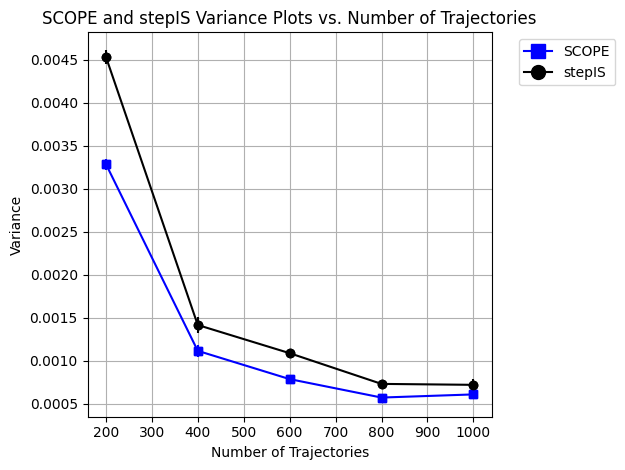

<Figure size 640x480 with 0 Axes>

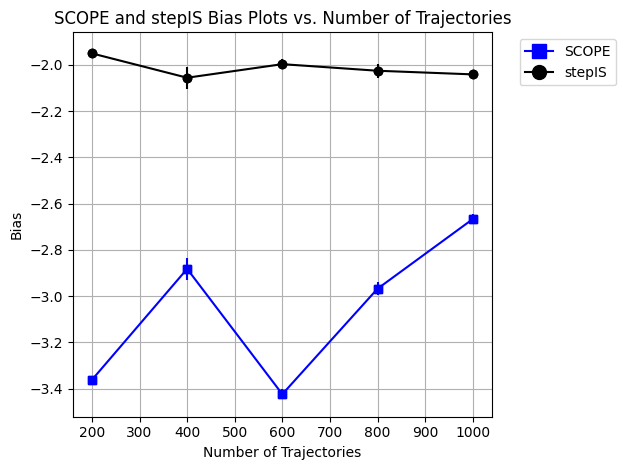

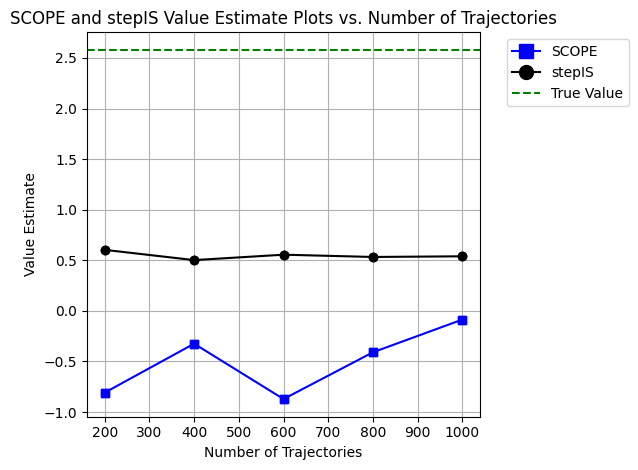

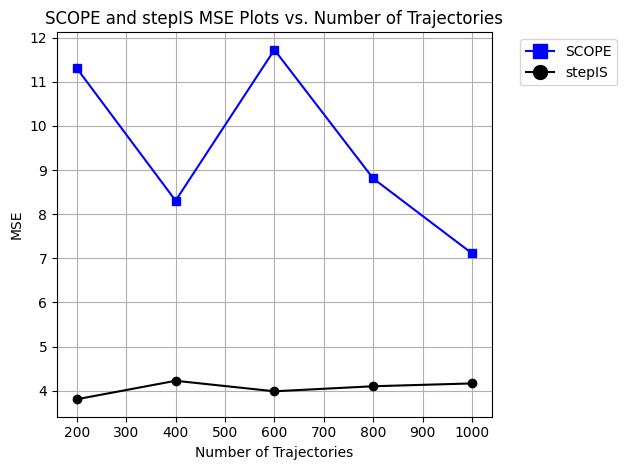

In [46]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 1), ((2, 3), 0), ((2, 4), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [0.06790277]
Variance Scope: 0.006930143782258151
----------
Var SCOPE_phi:  0.006888986861899462
Var IS_phi:  0.01080765905475034
Percent change in variance:  -36.25828843229918
SCOPE results:  {'std_devs_list': [0.044931659235920844, 0.044717055413638095, 0.04696461874049806, 0.04718924948703106, 0.04677300115838873], 'mean_list': [-0.7371194993255538, -0.735931559199347, -0.7348650336030862, -0.7342498054223886, -0.7390898780270914]}
IS results:  {'std_devs_list': [0.050278528062949655, 0.051006784206530244, 0.05221922719434066, 0.05212922755798577, 0.051994978152785525], 'mean_list': [0.3655129279819655, 0.36637886709588463, 0.36890188516784267, 0.36834050535664437, 0.36343362775149396]}
true eval:  2.3354751250394536
Loading  400  trajectories: 
Iteration: 1
Beta: [0.04751729]
Variance Scope: 0.002848399028159792
----------
Var SCOPE_phi:  0.0024574027384068405
Var IS_phi:  0.0030647942798450317
Percent change in variance:  -19.81834

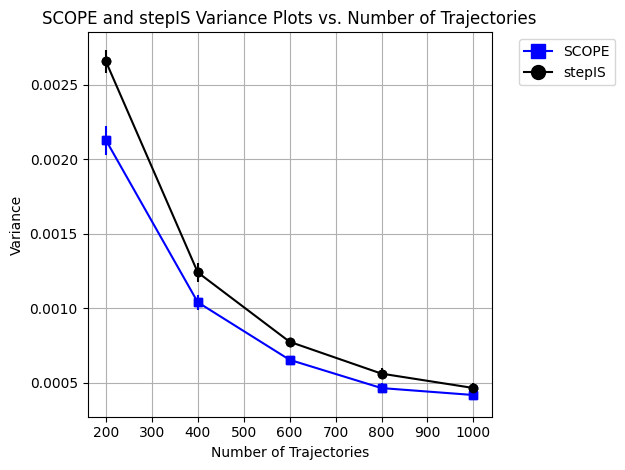

<Figure size 640x480 with 0 Axes>

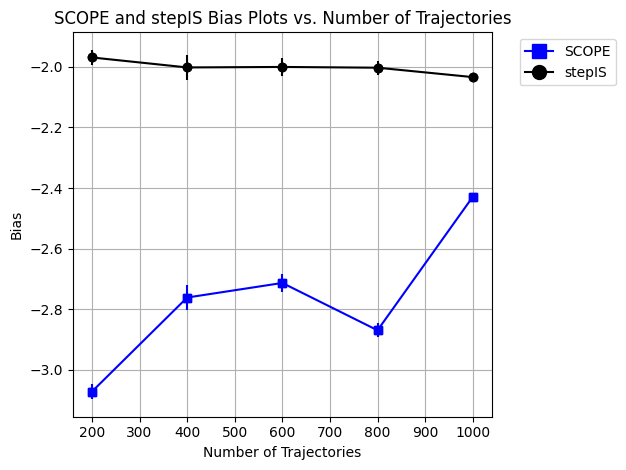

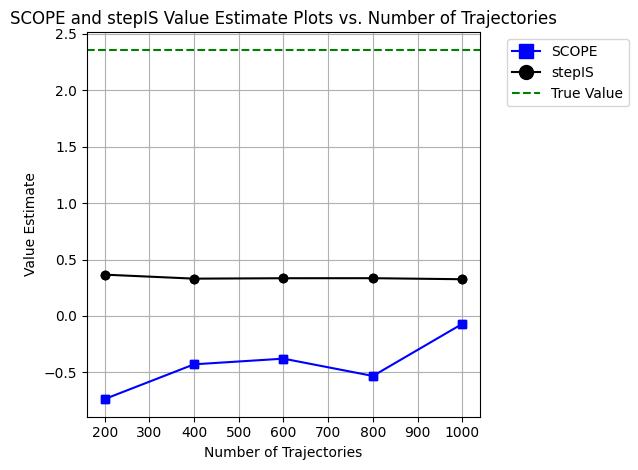

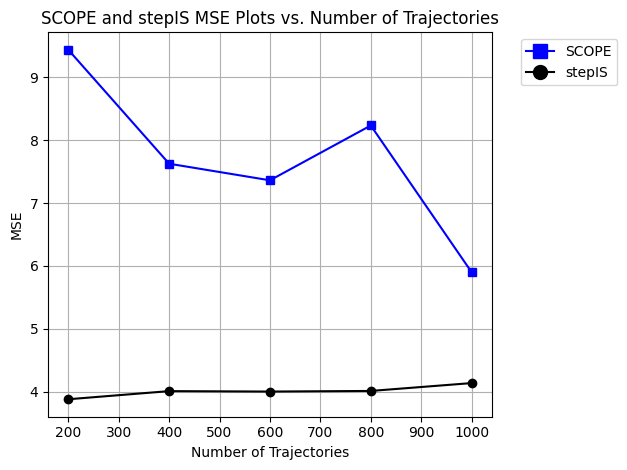

In [47]:
np.random.seed(42)
# Define the clusters with point-reward pairs
good_cluster_1 = [((2, 2), 0), ((2, 3), 1), ((2, 4), 0)]

env = GridWorld(height, width, start, end, bad_region_clusters=[],
    good_region_clusters=[good_cluster_1],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

## Sparse, 1 bad

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.03653492]
Variance Scope: 0.005523756107366266
----------
Var SCOPE_phi:  0.005689880545562066
Var IS_phi:  0.006378800586768915
Percent change in variance:  -10.800150151046054
SCOPE results:  {'std_devs_list': [0.04112659738880175, 0.043343232043567125, 0.04373170636478872, 0.041165406522538375, 0.042961635485095635], 'mean_list': [0.2528924575323789, 0.25355896146340184, 0.2485304600626449, 0.25399740411166993, 0.24939564573196113]}
IS results:  {'std_devs_list': [0.04441995517934967, 0.04723611660651575, 0.04699322193591984, 0.044465381175306413, 0.04623019061458447], 'mean_list': [-0.34037618432675415, -0.33953642854996086, -0.34534859211367896, -0.33924857705380307, -0.3438143911687654]}
true eval:  1.7903762807365589
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.04375821]
Variance Scope: 0.0022399087505431442
----------
Var SCOPE_phi:  0.002518498267858863
Var IS_phi:  0.0028485170529478077
Percent change in variance:  -1

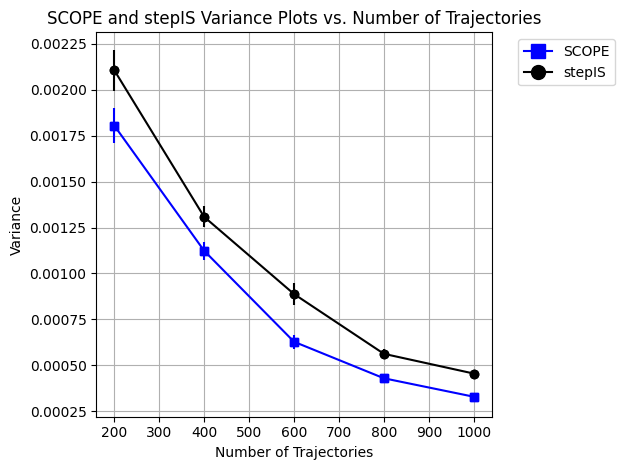

<Figure size 640x480 with 0 Axes>

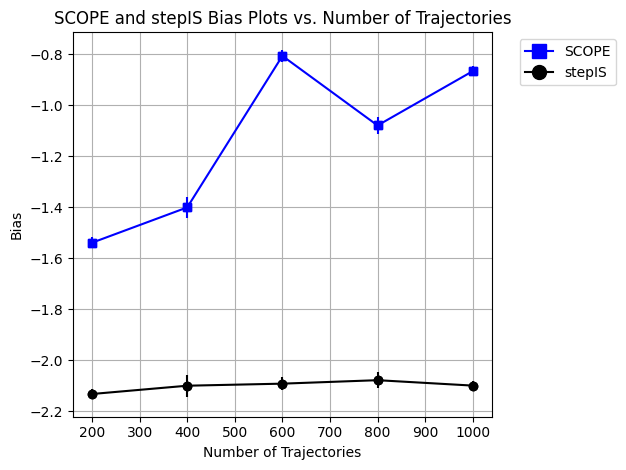

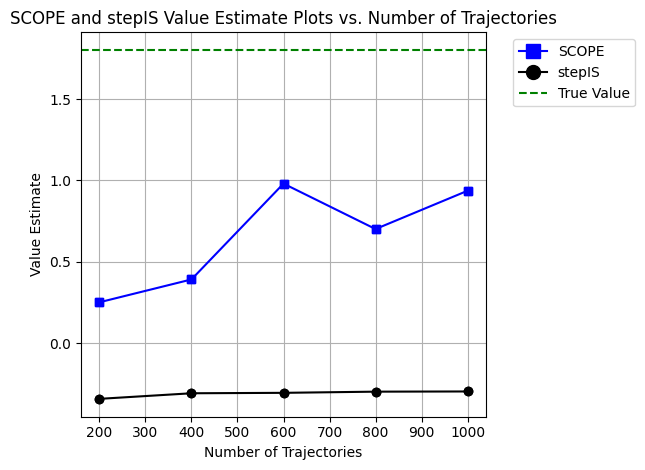

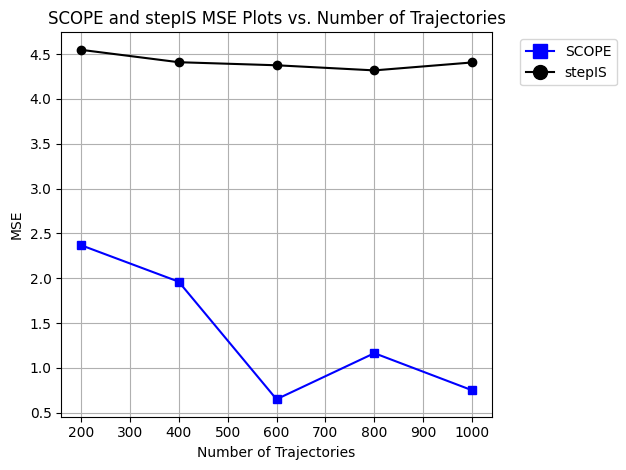

In [40]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.06790278]
Variance Scope: 0.00693014378225771
----------
Var SCOPE_phi:  0.006888986458575324
Var IS_phi:  0.01080765905475034
Percent change in variance:  -36.25829216413543
SCOPE results:  {'std_devs_list': [0.044931658237409064, 0.04471705415746759, 0.046964617728038026, 0.047189248547810834, 0.04677300019125719], 'mean_list': [0.737119787944712, 0.7359318477342202, 0.7348653225192029, 0.7342500940305229, 0.7390901666177387]}
IS results:  {'std_devs_list': [0.050278528062949655, 0.051006784206530244, 0.05221922719434066, 0.05212922755798577, 0.051994978152785525], 'mean_list': [-0.3655129279819655, -0.36637886709588463, -0.36890188516784267, -0.36834050535664437, -0.36343362775149396]}
true eval:  1.771935559154245
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.04751725]
Variance Scope: 0.0028483990281599667
----------
Var SCOPE_phi:  0.0024574026836768647
Var IS_phi:  0.0030647942798450317
Percent change in variance:  -19.818

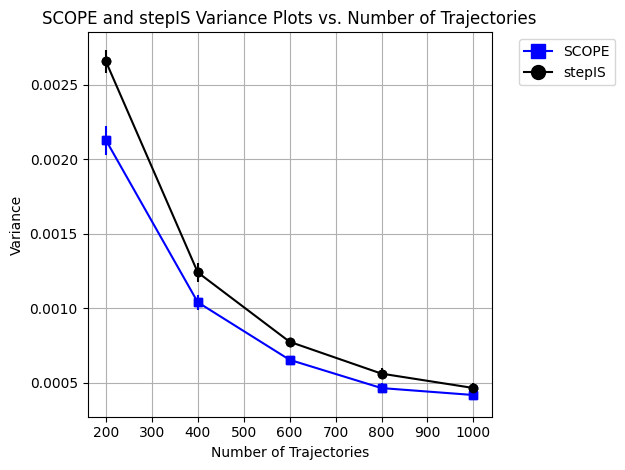

<Figure size 640x480 with 0 Axes>

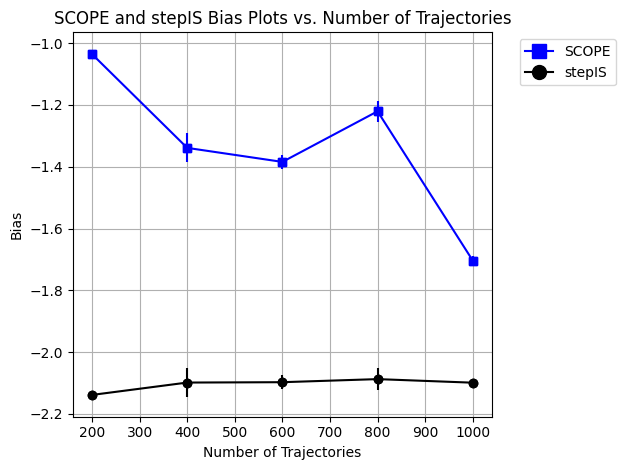

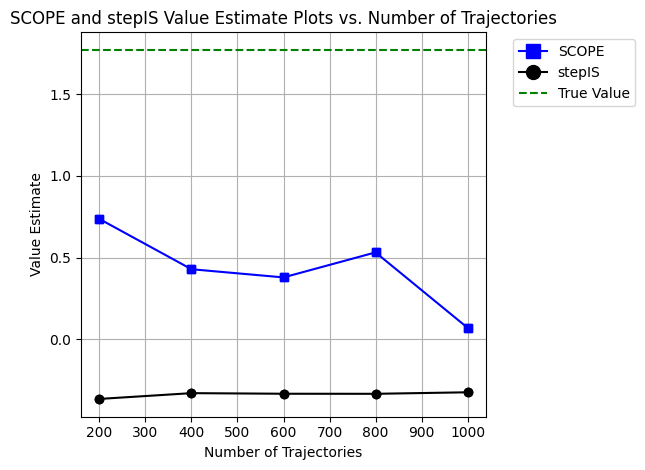

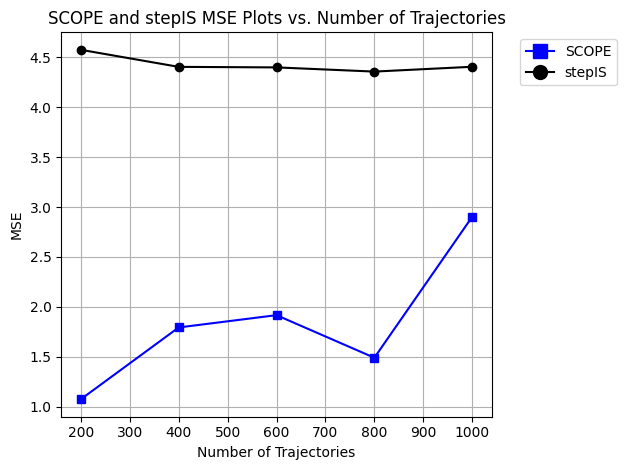

In [42]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), 0), ((3, 3), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.07676914]
Variance Scope: 0.0076531750314148585
----------
Var SCOPE_phi:  0.007800805424802978
Var IS_phi:  0.012777503511203991
Percent change in variance:  -38.94890799315517
SCOPE results:  {'std_devs_list': [0.04886203858998391, 0.04872992245903804, 0.05052310115615702, 0.05074636065583986, 0.051064115193154645], 'mean_list': [0.8194794273037603, 0.8188355807482536, 0.8173830519568794, 0.8169623018361636, 0.8212203048702797]}
IS results:  {'std_devs_list': [0.05548978504755789, 0.056512353620033054, 0.05689694465014883, 0.05700527366069244, 0.05742653250240559], 'mean_list': [-0.42712871947139336, -0.42740851988128853, -0.43050772198006265, -0.42959822906426665, -0.425264697997652]}
true eval:  1.7220345150162193
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.05929597]
Variance Scope: 0.003276100096384728
----------
Var SCOPE_phi:  0.002937435282936393
Var IS_phi:  0.003877070986891551
Percent change in variance:  -24.235710

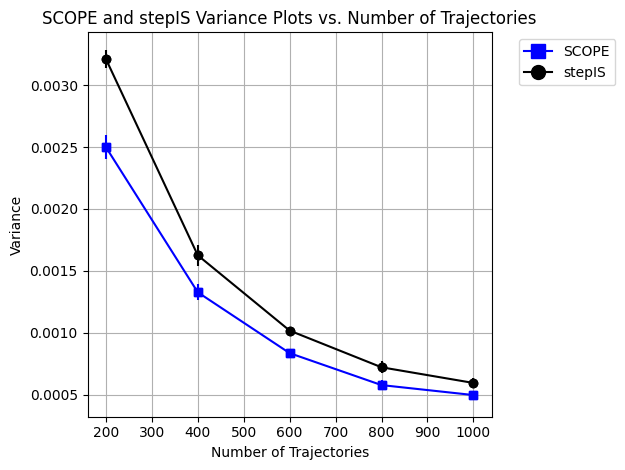

<Figure size 640x480 with 0 Axes>

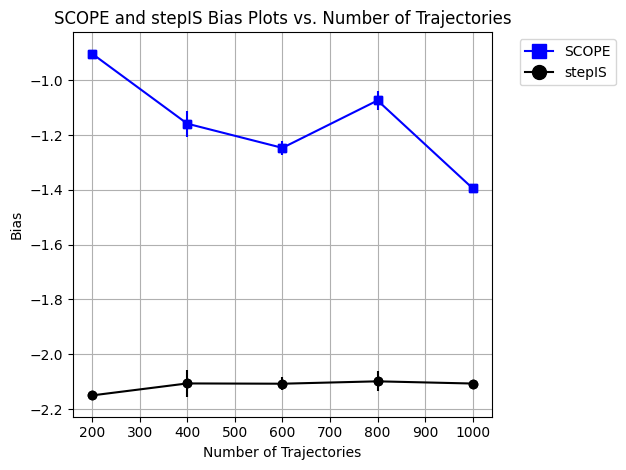

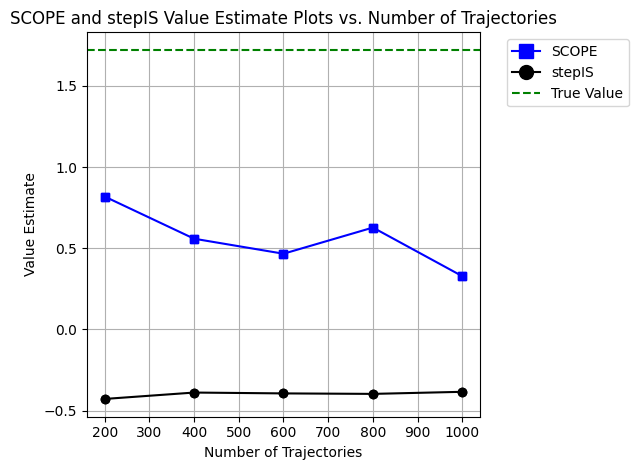

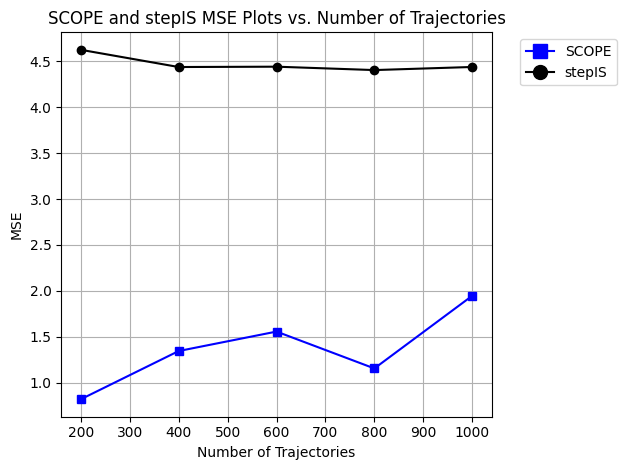

In [44]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -1), ((2, 4), -0.1), ((3, 3), -0.1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.04979667]
Variance Scope: 0.006102079075753092
----------
Var SCOPE_phi:  0.006356417467956044
Var IS_phi:  0.007830453416255573
Percent change in variance:  -18.82440096303382
SCOPE results:  {'std_devs_list': [0.04350014484952367, 0.04609798971525186, 0.046160702762912106, 0.04357151113827636, 0.04542169570868955], 'mean_list': [0.40484398121184983, 0.4055912203976832, 0.4004029330873609, 0.40557859550737513, 0.40126349270483436]}
IS results:  {'std_devs_list': [0.048427066849438725, 0.05180726247487863, 0.0509663704060936, 0.04844236304864767, 0.05024976583532279], 'mean_list': [-0.40377433701061116, -0.402790957556658, -0.4090473673591491, -0.40300883645091423, -0.4072749476350579]}
true eval:  1.7340920191131037
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.0641336]
Variance Scope: 0.002363744616816281
----------
Var SCOPE_phi:  0.0027457521359645076
Var IS_phi:  0.0037487239961950247
Percent change in variance:  -26.755020

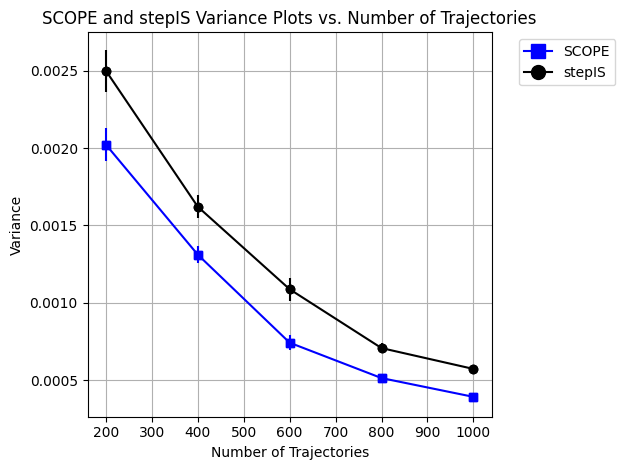

<Figure size 640x480 with 0 Axes>

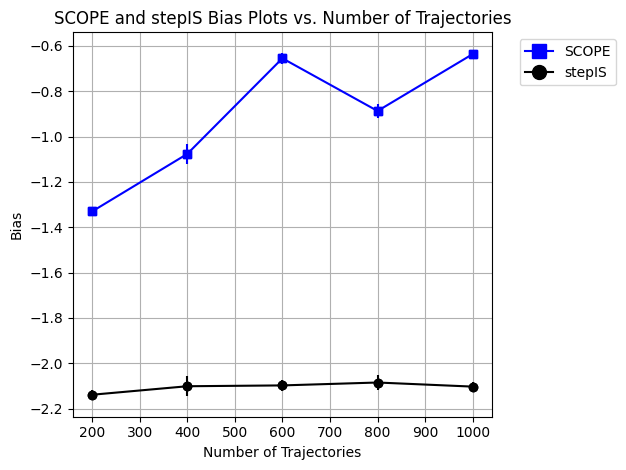

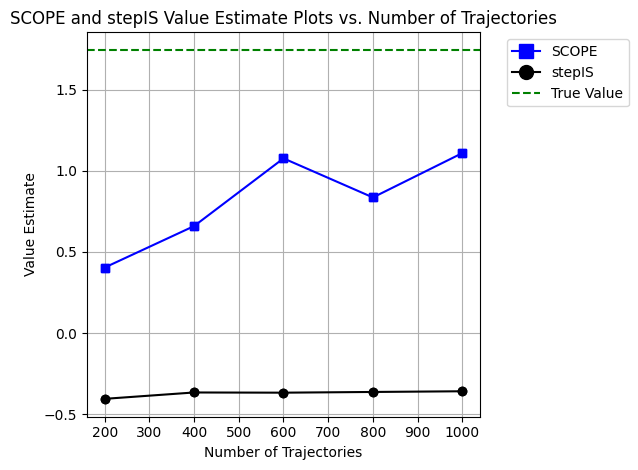

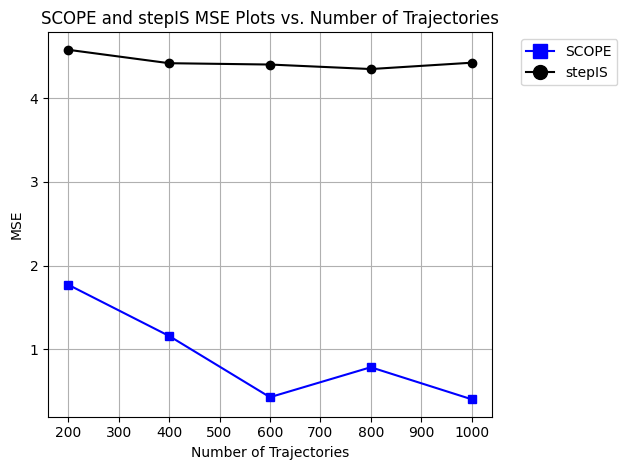

In [48]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 3), -0.1), ((2, 4), 0), ((3, 3), -1),((3,4),-0.1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.04671999]
Variance Scope: 0.005189135115256248
----------
Var SCOPE_phi:  0.005271515529368697
Var IS_phi:  0.00622265727794874
Percent change in variance:  -15.285137941801938
SCOPE results:  {'std_devs_list': [0.036114570008184035, 0.036965949381194275, 0.03559581666865901, 0.03582806789443253, 0.03492634890486973], 'mean_list': [0.4123037716553755, 0.4145941983228416, 0.41190314857757204, 0.4143932325783256, 0.41426886442892696]}
IS results:  {'std_devs_list': [0.03918227285238001, 0.04051546903021404, 0.038978681277295556, 0.03875552070967164, 0.03817038101555684], 'mean_list': [-0.33277345432310174, -0.33115044498396484, -0.3335871525583275, -0.3303115190296623, -0.3313870638949611]}
true eval:  1.7186321485303846
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.03113866]
Variance Scope: 0.0014446863390910865
----------
Var SCOPE_phi:  0.001557002452602137
Var IS_phi:  0.001756820581655244
Percent change in variance:  -11.3738

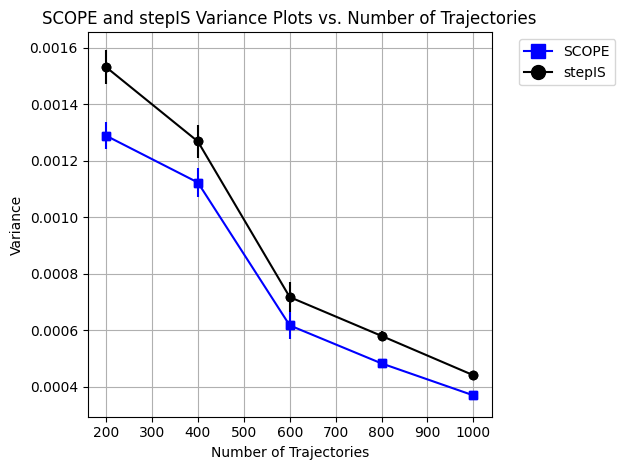

<Figure size 640x480 with 0 Axes>

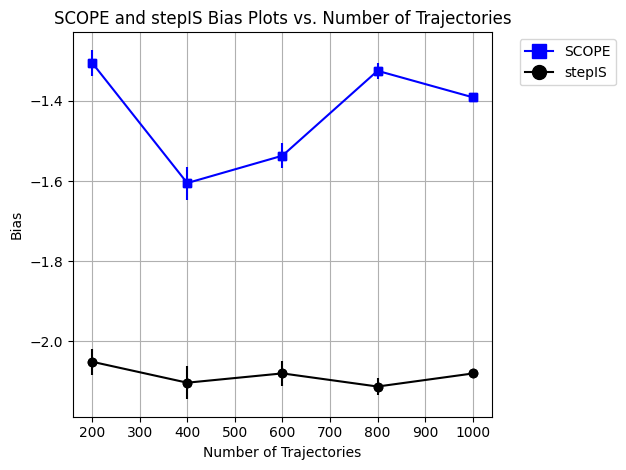

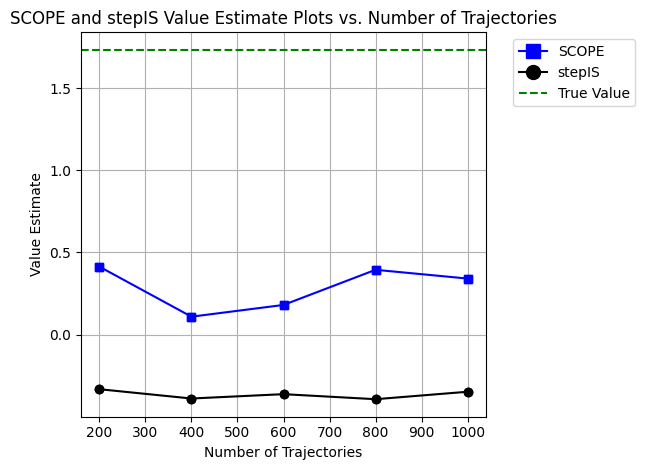

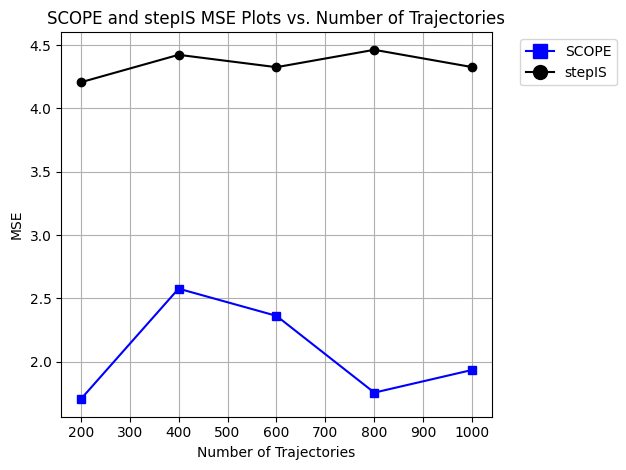

In [49]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), -0.1), ((2, 2), 0), ((3, 2), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.08689777]
Variance Scope: 0.013189408466888578
----------
Var SCOPE_phi:  0.010584607320340859
Var IS_phi:  0.015360901040530783
Percent change in variance:  -31.09383822984959
SCOPE results:  {'std_devs_list': [0.05749887574730853, 0.05675050296362503, 0.0565940137887599, 0.05810359976876118, 0.05760815964987942], 'mean_list': [0.8088431678007559, 0.8054583787909375, 0.8080969372294275, 0.8077404096230457, 0.810507075151113]}
IS results:  {'std_devs_list': [0.06792751996911568, 0.06723921413896543, 0.06629412163452625, 0.06718188853526989, 0.06793467431177252], 'mean_list': [-0.6022378287616046, -0.605210540729192, -0.604435911559598, -0.6032866888028949, -0.6004345303541837]}
true eval:  1.5538684673974825
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.05169971]
Variance Scope: 0.0018639839488090305
----------
Var SCOPE_phi:  0.0018306953034368367
Var IS_phi:  0.002398038699828242
Percent change in variance:  -23.65864222424938

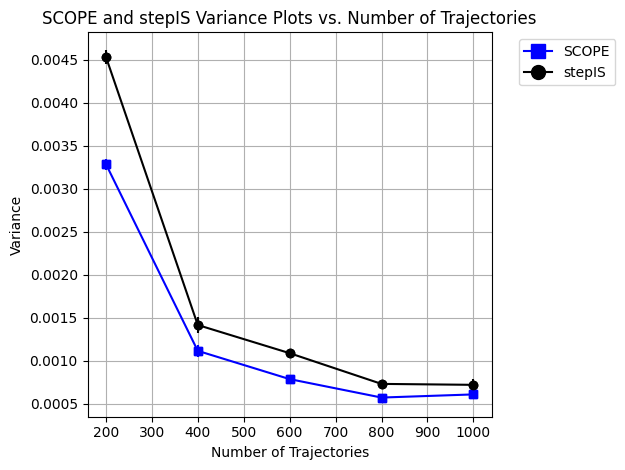

<Figure size 640x480 with 0 Axes>

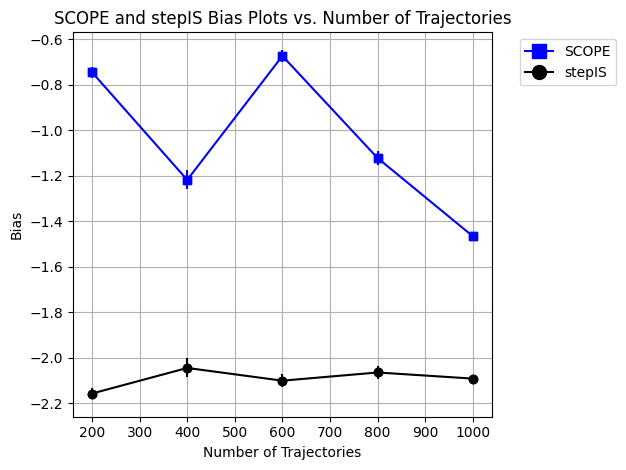

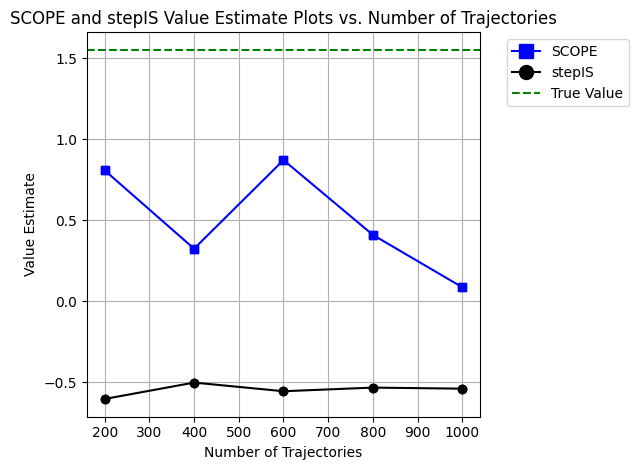

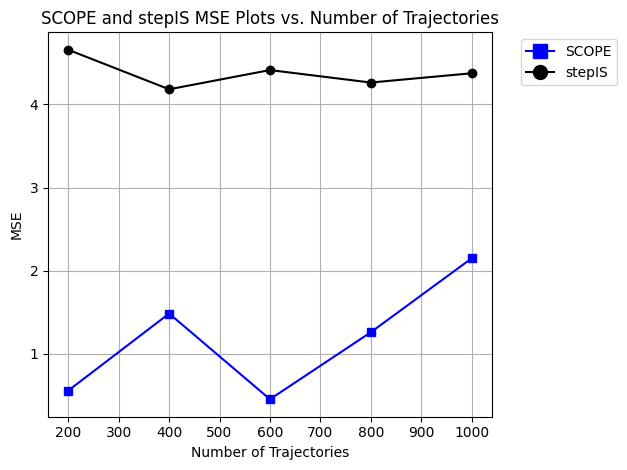

In [50]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((2, 1), 0), ((2, 2), -1), ((3, 2), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Loading  400  trajectories: 
Loading  600  trajectories: 
Loading  800  trajectories: 
Loading  1000  trajectories: 
Iteration: 1
Beta: [0.00929423]
Variance Scope: 0.00026369570917906583
----------
Var SCOPE_phi:  0.00026895310808013
Var IS_phi:  0.00025943700069979564
Percent change in variance:  3.6679838861326606
SCOPE results:  {'std_devs_list': [0.008856664994760408, 0.008405427984088129, 0.009146583677984044, 0.008893538890838317, 0.008777406983546785], 'mean_list': [-0.27483036613076023, -0.2754299590384329, -0.2752502474954407, -0.2750921804290889, -0.27546597081221597]}
IS results:  {'std_devs_list': [0.00880301940484976, 0.008380284246909864, 0.009049629639228436, 0.008831456119525185, 0.008709951389118665], 'mean_list': [-0.12608479917690757, -0.12663985582823112, -0.12650857713473648, -0.12633478647001403, -0.12663935319714617]}
true eval:  1.972541520810945
Trajectories:  200
True Val:  [1.9878620807092677, 1.9578701039599804, 1.96464669487159

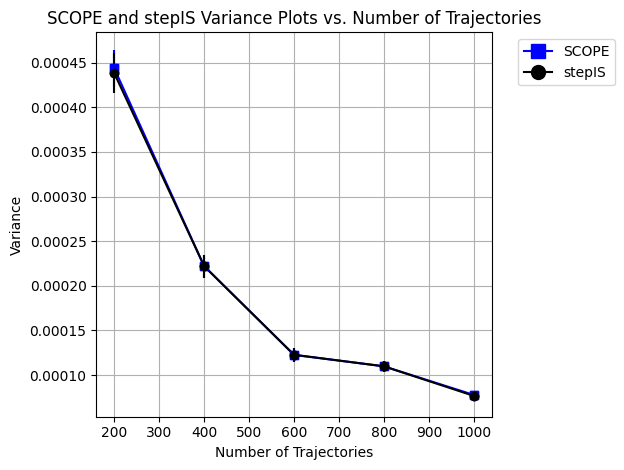

<Figure size 640x480 with 0 Axes>

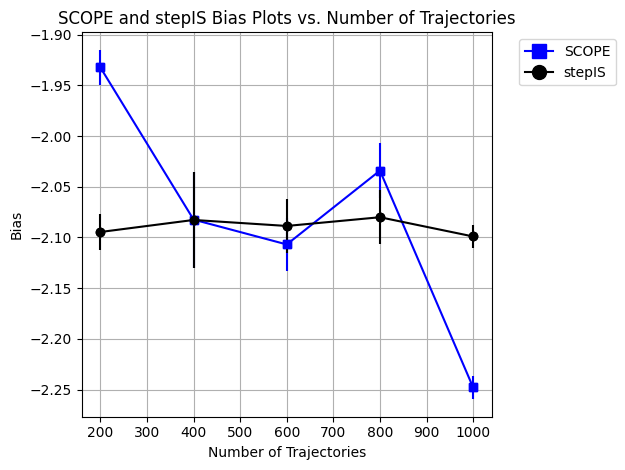

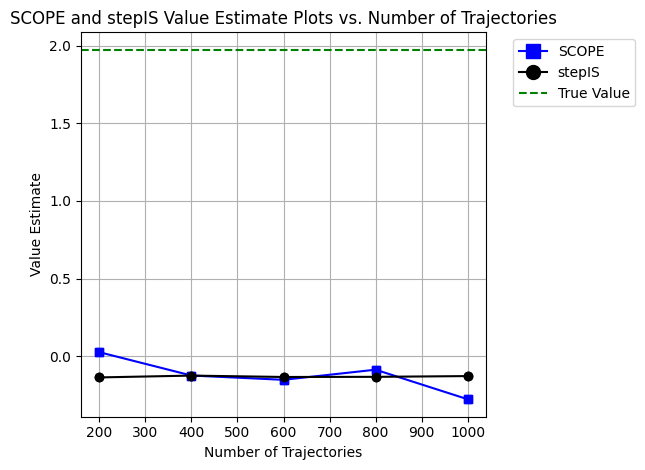

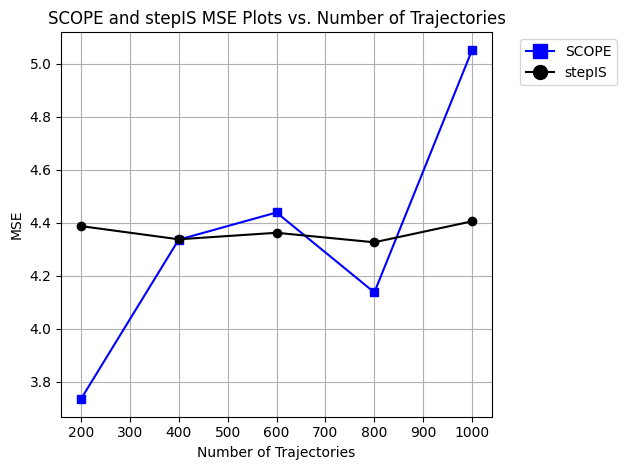

In [40]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((0, 3), 0), ((1, 3), -1), ((1, 2), 0)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.00237386]
Variance Scope: 0.0006486798359792599
----------
Var SCOPE_phi:  0.0007063703536617636
Var IS_phi:  0.0007145568812281997
Percent change in variance:  -1.1456789209509564
SCOPE results:  {'std_devs_list': [0.016325952283767473, 0.017227892441599762, 0.01722642017209253, 0.017104003890466152, 0.016591749509661212], 'mean_list': [-0.13602506260580607, -0.13606801663730952, -0.1365241829200277, -0.13585753119445643, -0.13557532619187118]}
IS results:  {'std_devs_list': [0.016253546892752976, 0.017219694638054537, 0.01720597821643317, 0.01709670670522314, 0.01657326686598343], 'mean_list': [-0.17457267778003796, -0.17460437477719343, -0.17511145948935994, -0.17440367399068415, -0.1741191335103956]}
true eval:  1.9095153201911437
Loading  400  trajectories: 
Iteration: 1
Beta: [0.00139708]
Variance Scope: 0.00026717239015596947
----------
Var SCOPE_phi:  0.00028574413111826175
Var IS_phi:  0.00028274851613904056
Percent change in

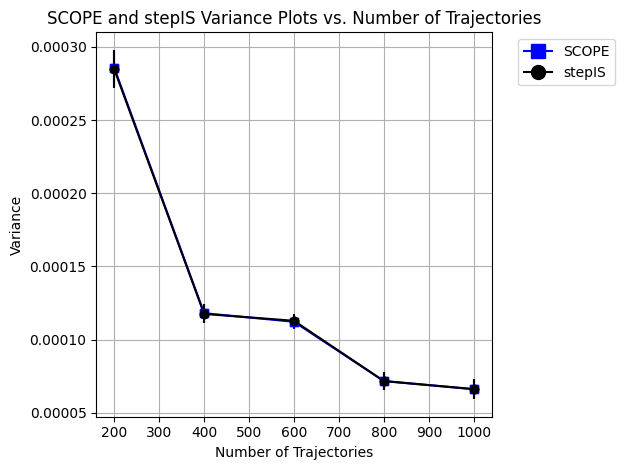

<Figure size 640x480 with 0 Axes>

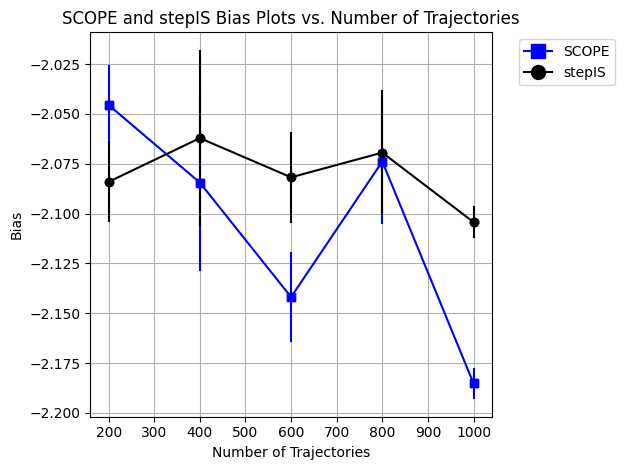

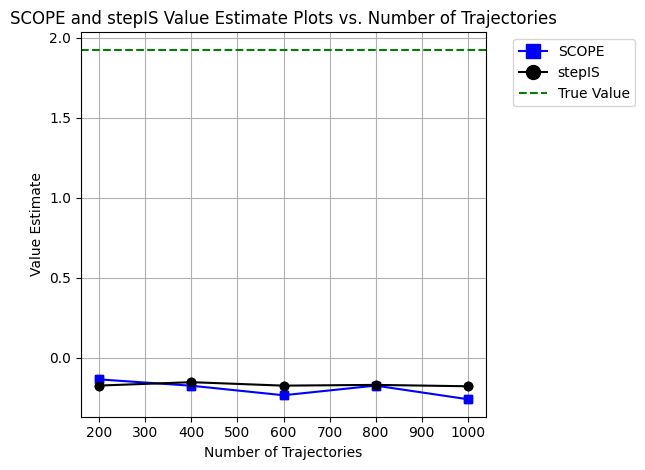

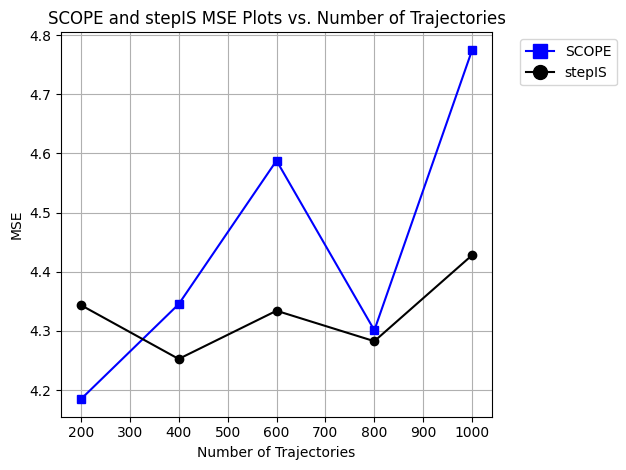

In [41]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((0, 3), -1), ((1, 3), -0.2), ((1, 2), -0.2)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

Loading  200  trajectories: 
Iteration: 1
Beta: [0.00937638]
Variance Scope: 0.004362448884888722
----------
Var SCOPE_phi:  0.004620042541095521
Var IS_phi:  0.004690021349796236
Percent change in variance:  -1.4920786811291438
SCOPE results:  {'std_devs_list': [0.04943202107967048, 0.04698029975909102, 0.04951802796126966, 0.049556368979063334, 0.047598921649798856], 'mean_list': [-0.8963190392768545, -0.8963838040332256, -0.8943928363770708, -0.9000737599268112, -0.8961901063008829]}
IS results:  {'std_devs_list': [0.04946992887250045, 0.04708767267711679, 0.04953957029691506, 0.04952440142065457, 0.04765673327427174], 'mean_list': [-0.7440616557394675, -0.7441708841179969, -0.7419787961900276, -0.7478221920649585, -0.7439477632308319]}
true eval:  1.4727429999543218
Loading  400  trajectories: 
Iteration: 1
Beta: [0.00872031]
Variance Scope: 0.002879615968363289
----------
Var SCOPE_phi:  0.0027202010652507278
Var IS_phi:  0.0027596307868490433
Percent change in variance:  -1.42880

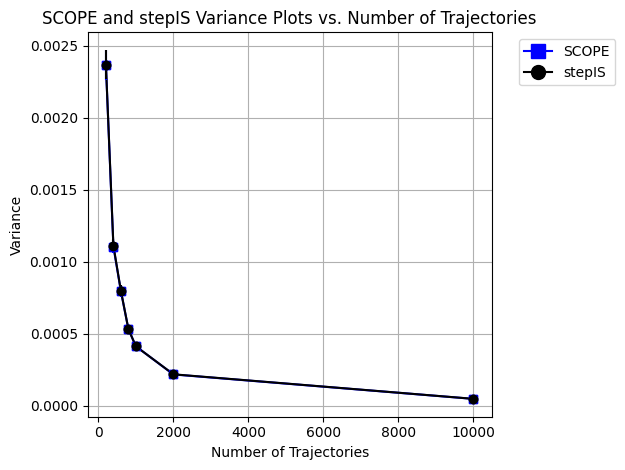

<Figure size 640x480 with 0 Axes>

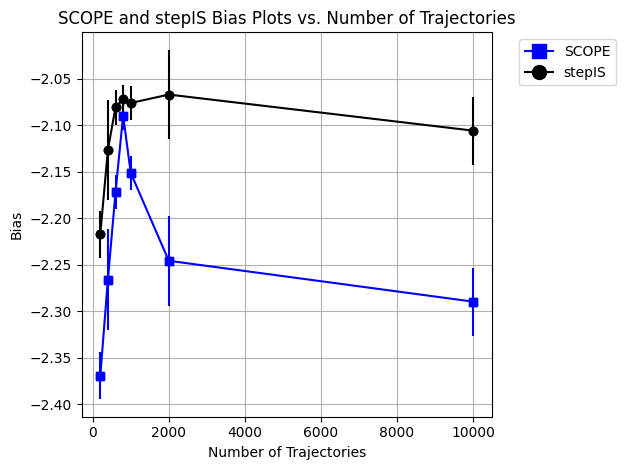

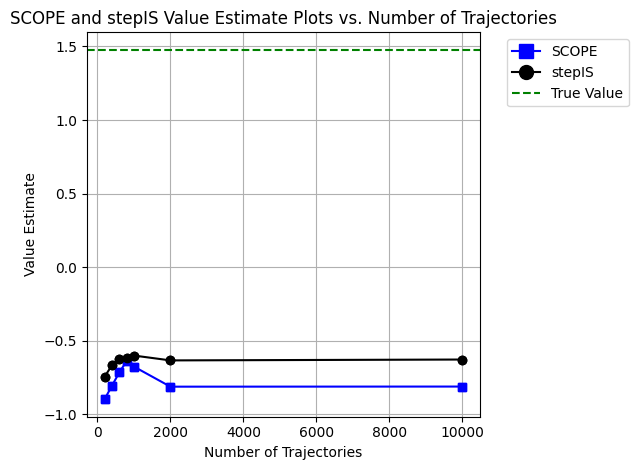

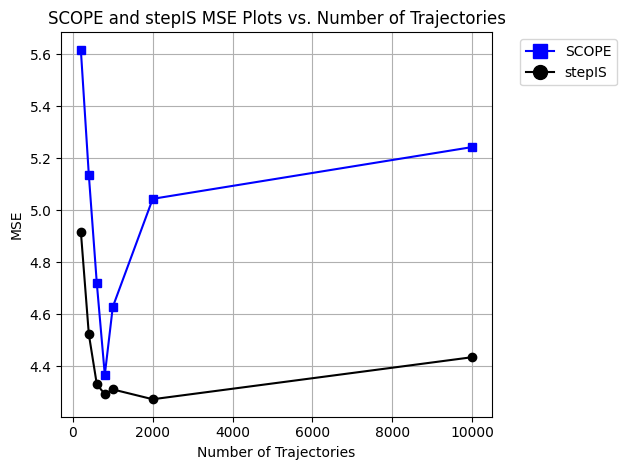

In [41]:
np.random.seed(42)
# Define the clusters with point-reward pairs
# bad_cluster_1 = [((2, 3), 0), ((2, 4), 0), ((3, 3), -1)]
bad_cluster_1 = [((1, 0), 0), ((1, 1), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000, 2000,10000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

## Dense, 1 bad,

Loading  200  trajectories: 
Iteration: 1
Beta: [-0.0341819]
Variance Scope: 0.010542939393610801
----------
Var SCOPE_phi:  0.010439200573447667
Var IS_phi:  0.01126166300361986
Percent change in variance:  -7.30320584009508
SCOPE results:  {'std_devs_list': [0.058009262419951094, 0.060019880930269984, 0.060146524559073385, 0.05996047242083269, 0.05852535970523911], 'mean_list': [-0.12061129080682581, -0.12116222559523072, -0.12192247713975554, -0.12091524477449914, -0.11775151444199848]}
IS results:  {'std_devs_list': [0.058609994773193314, 0.061011464156344584, 0.06112527829729719, 0.060998649567713815, 0.05986776679832818], 'mean_list': [-0.6756707847284231, -0.6760596258630442, -0.6775530682302218, -0.6759535374522291, -0.6727561778260295]}
true eval:  1.5050395064885318
Loading  400  trajectories: 
Iteration: 1
Beta: [-0.00779557]
Variance Scope: 0.0033663274052930054
----------
Var SCOPE_phi:  0.0036069597201971435
Var IS_phi:  0.003690644061290771
Percent change in variance:  -

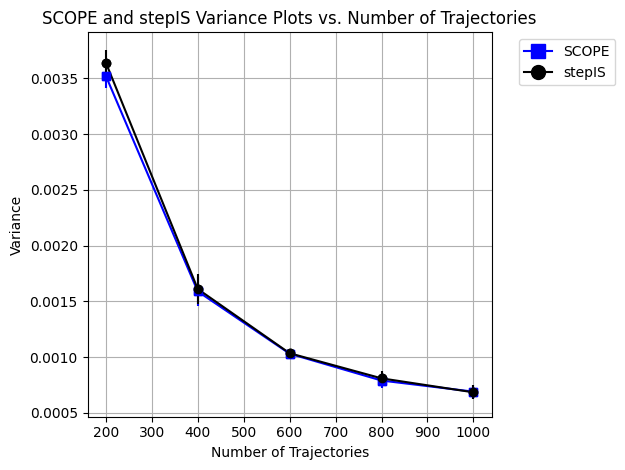

<Figure size 640x480 with 0 Axes>

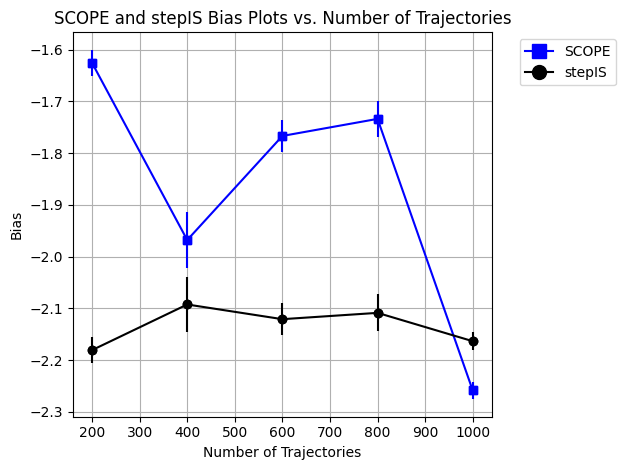

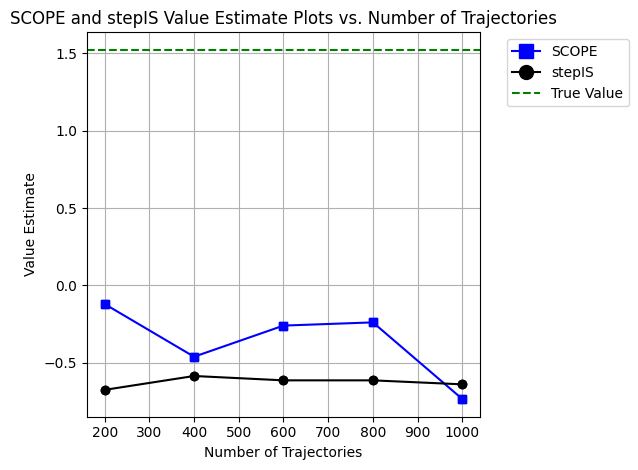

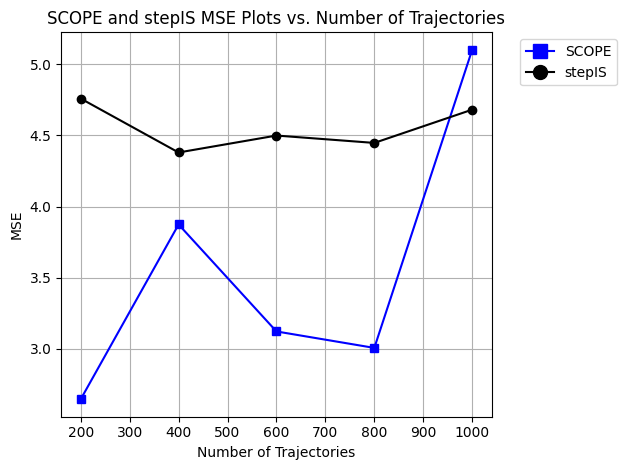

In [42]:
np.random.seed(42)
# Define the clusters with point-reward pairs
bad_cluster_1 = [((0, 3), -1), ((1, 3), -1), ((1, 2), -1)]
# good_cluster = []
env = GridWorld(height, width, start, end, bad_region_clusters=[bad_cluster_1],
    good_region_clusters=[],final_reward = 10, sparsity = 0.0)
num_trajectories = [200,400, 600, 800,1000]
compare_experiments_over_trajectories(env, behav_policy_quad, eval_policy_quad, num_trajectories, 0.3, 0.0 )

## Sparse, 1 bad, similar